# Airfoil optimization

In [1]:
from IPython.display import SVG, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch import distributions
from torch.distributions import Normal

#stuff for neurofoil - pip install neuralfoil
from aerosandbox.geometry.airfoil.airfoil_families import get_kulfan_parameters, get_kulfan_coordinates
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p


import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import sys
import os
import contextlib
from collections import deque
import copy

## Procedure 

Sources:
* http://servidor.demec.ufpr.br/CFD/bibliografia/aerodinamica/kulfan_2007.pdf
* https://www.tandfonline.com/doi/epdf/10.1080/19942060.2024.2445144
* https://github.com/peterdsharpe/NeuralFoil


Here the PINN is allready trained an provides the prediction. Therefore, the idea is, we shift the quantum opt. part to approximate a policy. 

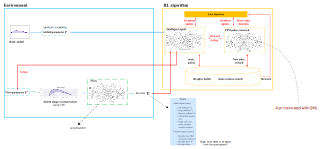

In [2]:
display(SVG(filename="optimprocedure.svg"))

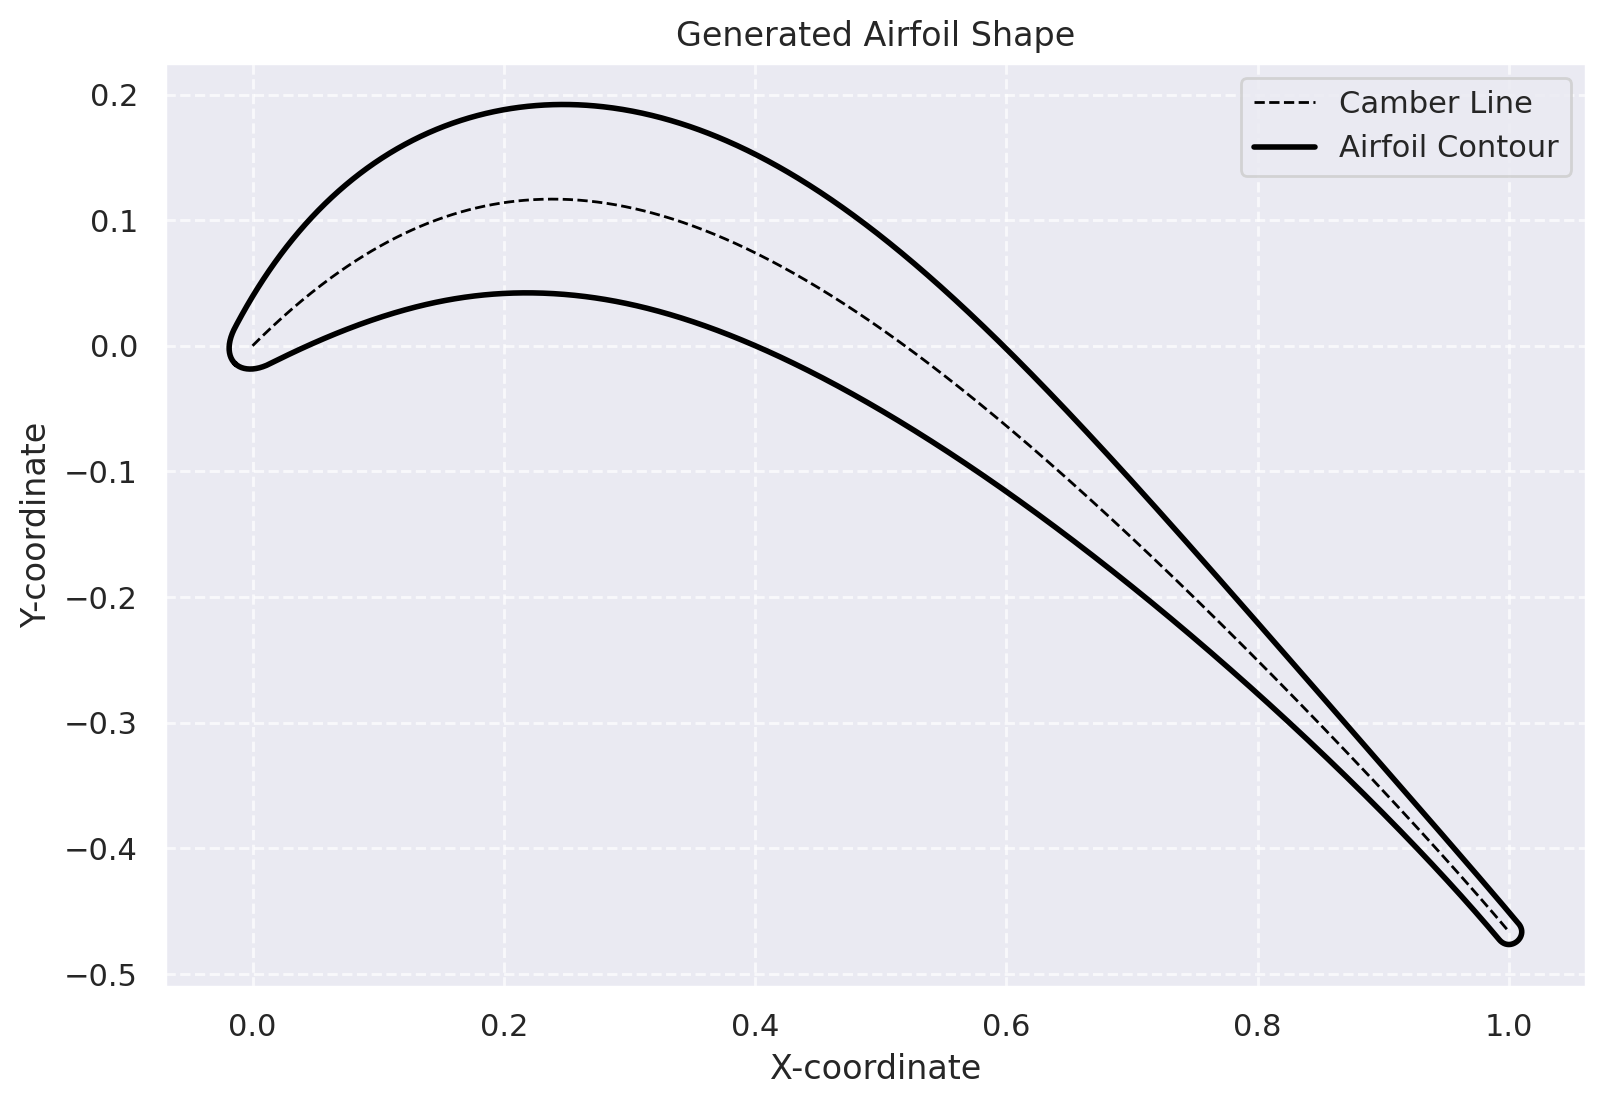

In [3]:
sys.path.append(os.path.abspath("../blade_design_tools"))
import create_airfoil as ca
airfoil_top_points, airfoil_bottom_points, camber_curve_points = ca.generate_shape(config_filepath="../blade_design_tools/airfoil_config.yaml")

In [4]:
def get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points):
    """
        stacking is up for neurofoil
    """
    # Upper surface: reverse to go from TE to LE
    upper_te_to_le = np.flip(airfoil_top_points, axis=0)

    # Lower surface: LE to TE as is
    lower_le_to_te = airfoil_bottom_points

    # Check if LE points match (for sharp LE); avoid duplicating if so
    if np.allclose(upper_te_to_le[-1], lower_le_to_te[0]):
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te[1:]))
    else:
        coordinates = np.vstack((upper_te_to_le, lower_le_to_te))
    return coordinates


# 7. Export for NeuralFoil
coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
kulfan_params = get_kulfan_parameters(coordinates)
print("Kulfan parameters:", kulfan_params)

Kulfan parameters: {'lower_weights': array([-0.39463068,  0.5726026 ,  0.17745471,  0.6048875 ,  0.28333585,
        0.40413929,  0.45693178,  0.35682846]), 'upper_weights': array([0.67150686, 0.39899314, 1.0069387 , 0.45522572, 0.61792343,
       0.60628315, 0.35938593, 0.60352649]), 'TE_thickness': 0.01324605086387115, 'leading_edge_weight': 1.103184527384567}


In [5]:
CL_multipoint_targets = np.array([0.8, 1.0, 1.2, 1.4, 1.5, 1.6])
CL_multipoint_weights = np.array([5, 6, 7, 8, 9, 10])

Re = 500e3 * (CL_multipoint_targets / 1.25) ** -0.5
mach = 0.7

In [6]:
def opt_state(initial_guess_airfoil):
    opti_ = asb.Opti()
    optimized_airfoil_ = asb.KulfanAirfoil(
        name="Optimized",
        lower_weights=opti_.variable(
            init_guess=initial_guess_airfoil.lower_weights,
            lower_bound=-0.5,
            upper_bound=0.25,
        ),
        upper_weights=opti_.variable(
            init_guess=initial_guess_airfoil.upper_weights,
            lower_bound=-0.25,
            upper_bound=0.5,
        ),
        leading_edge_weight=opti_.variable(
            init_guess=initial_guess_airfoil.leading_edge_weight,
            lower_bound=-1,
            upper_bound=1,
        ),
        TE_thickness=kulfan_params["TE_thickness"],
    )

    alpha_ = opti_.variable(
        init_guess=45
    )


    aero_ = optimized_airfoil_.get_aero_from_neuralfoil(
        alpha=alpha_,
        Re=Re,
        mach=mach,
    )
    return aero_, optimized_airfoil_, alpha_, opti_

# Test optimization frame work
### TODO's: 
- Implement real costfunction
- Shape constraints
- Implement the PPO, here we compare standard PPO vs. Quantum PPO

In [7]:
#needs to be refined for the ppo
def get_optim(opti_, aero_, target_, initial_guess, alpha_):
    opti_.subject_to([
        aero_["analysis_confidence"] > 0.90,
        aero_["CL"] == CL_multipoint_targets,
        np.diff(alpha_) > 0,
        aero_["CM"] >= -0.133,
        target_.local_thickness(x_over_c=0.33) >= 0.128,
        target_.local_thickness(x_over_c=0.90) >= 0.014,
        target_.TE_angle() >= 6.03, 
        target_.lower_weights[0] < -0.05,
        target_.upper_weights[0] > 0.05,
        target_.local_thickness() > 0
    ])
    
    get_wiggliness = lambda af: sum([
        np.sum(np.diff(np.diff(array)) ** 2)
        for array in [af.lower_weights, af.upper_weights]
    ])
    
    opti_.subject_to(
        get_wiggliness(target_) < 2 * get_wiggliness(initial_guess)
    )
    
    
    # Formulate an optimization goal based
    opti_.maximize(np.mean(aero_["CL"] / aero_["CD"]))
    
    sol = opti_.solve(
        max_iter = 0,
        behavior_on_failure="return_last",
        options={
           # "ipopt.mu_strategy": 'monotone',
           # "ipopt.start_with_resto": 'yes'
        }
    )
    return sol

#optimized_airfoil_0 = sol(optimized_airfoil)

### Interface for NeuralFoil
This provides the values employed for guiding the optimization, here the method call for `get_aero_from_neuralfoil` yields the following values. Question: how to use this parameter to approximate our loss value sought? 

```python
return {
            "analysis_confidence": nf_aero["analysis_confidence"],
            "CL": CL,
            "CD": CD,
            "CM": CM,
            "Cpmin": Cpmin,
            "Top_Xtr": Top_Xtr,
            "Bot_Xtr": Bot_Xtr,
            "mach_crit": mach_crit,
            "mach_dd": mach_dd,
            "Cpmin_0": Cpmin_0,
            **{f"upper_bl_theta_{i}": nf_aero[f"upper_bl_theta_{i}"] for i in range(N)},
            **{f"upper_bl_H_{i}": nf_aero[f"upper_bl_H_{i}"] for i in range(N)},
            **{
                f"upper_bl_ue/vinf_{i}": nf_aero[f"upper_bl_ue/vinf_{i}"]
                for i in range(N)
            },
            **{f"lower_bl_theta_{i}": nf_aero[f"lower_bl_theta_{i}"] for i in range(N)},
            **{f"lower_bl_H_{i}": nf_aero[f"lower_bl_H_{i}"] for i in range(N)},
            **{
                f"lower_bl_ue/vinf_{i}": nf_aero[f"lower_bl_ue/vinf_{i}"]
                for i in range(N)
            },
        }
```

Hint the returns values such as CL are wrapped into Casadi type. Therefore we need to employ solve to evaluate the AD graph. 

In [8]:
#modified shape_method
def generate_shape(config_filepath="airfoil_config.yaml", config_dict=None, plot_foil=False):
    try:
        config = ca.load_config(config_filepath) if config_dict is None else config_dict
        
        # Handle optional input targets for chord and max thickness
        input_targets = config.get('input_targets', {})
        desired_chord = input_targets.get('desired_chord_length', None)
        desired_max_th = input_targets.get('desired_max_thickness', None)
        
        # Temporarily compute camber to get normalized chord (needed for adjustments)
        temp_camber_control_points, temp_camber_curve_points = ca.compute_curve_points(
            config['camber_line'], "camber", config['output_settings']['num_points_on_curve']
        )
        norm_le = temp_camber_curve_points[0]
        norm_te = temp_camber_curve_points[-1]
        norm_chord = np.linalg.norm(norm_te - norm_le)
        norm_x_span = norm_te[0] - norm_le[0]  # Should be 1.0
        
        # Adjust chord_length_for_export if desired_chord is set (to achieve desired geometric chord)
        if desired_chord is not None:
            config['output_settings']['chord_length_for_export'] = desired_chord * (norm_x_span / norm_chord)  # Equivalent to desired_chord * np.cos(np.deg2rad(np.abs(config['camber_line']['stagger_angle_deg'])))
        
        # 1. Compute Camber Line
        camber_control_points, camber_curve_points = ca.compute_curve_points(
            config['camber_line'], "camber", config['output_settings']['num_points_on_curve']
        )
       
        # 2. Compute Top Thickness Distribution
        top_thickness_control_points, top_thickness_curve_points = ca.compute_curve_points(
            config['top_thickness'], "top_thickness", config['output_settings']['num_points_on_curve']
        )
        # 3. Compute Bottom Thickness Distribution
        bottom_thickness_control_points, bottom_thickness_curve_points = ca.compute_curve_points(
            config['bottom_thickness'], "bottom_thickness", config['output_settings']['num_points_on_curve']
        )
        
        # Temporarily compute current normalized max thickness
        current_norm_thickness_along = top_thickness_curve_points[:, 1] + bottom_thickness_curve_points[:, 1]
        current_norm_max_th = np.max(current_norm_thickness_along)
        
        # Compute scale factor (reflects any chord adjustment)
        scale = config['output_settings']['chord_length_for_export'] / norm_x_span
        
        # Adjust thickness curves if desired_max_th is set
        if desired_max_th is not None:
            desired_norm_max_th = desired_max_th / scale
            th_scale_factor = desired_norm_max_th / current_norm_max_th
            top_thickness_curve_points[:, 1] *= th_scale_factor
            bottom_thickness_curve_points[:, 1] *= th_scale_factor
        
        # 4. Generate Full Airfoil Contour
        airfoil_top_points, airfoil_bottom_points = ca.generate_airfoil_contour(
            camber_curve_points,
            top_thickness_curve_points,
            bottom_thickness_curve_points,
            config['camber_line']['inlet_angle_deg'],
            config['output_settings']['num_points_on_arc']
        )
        # 5. Plot the Airfoil
        if plot_foil:
            ca.plot_airfoil(camber_curve_points, airfoil_top_points, airfoil_bottom_points,
                         config['output_settings']['plot_title'])
    except:
        pass
       
    return airfoil_top_points, airfoil_bottom_points, camber_curve_points

In [9]:
# Starting with to adjustable params:
# NetworkA -> ChordLength + MaxThickness - using black box function to translate this into our parametrization
config = ca.load_config("../blade_design_tools/airfoil_config.yaml")

In [10]:
config['input_targets'] = {
    "desired_chord_length" : 1.0,
    "desired_max_thickness": 0.05
}

# Actor crtitic training
- For the purpose of a prototype, we start modifying a few control points
```python
camber_line:
  control_points_params:
    P1_k_factor: 0.4
    P2_x: 0.5
    P2_y: 0.05
    P3_k_factor: -0.25
  inlet_angle_deg: 45
  outlet_angle_deg: -50
  stagger_angle_deg: -25

top_thickness:
  control_points_params:
    P1_k_factor: 0.2
    P2_x: 0.1
    P2_y: 0.03
    P3_k_factor: 0
  inlet_angle_deg: 40
  outlet_angle_deg: -0
  le_y_thickness: 0.02 # Y-coordinate of P0 for thickness curve (half-thickness at LE)
  p4_y: 0.01           # Y-coordinate of P4 for thickness curve (half-thickness at TE)

bottom_thickness:
  control_points_params:
    P1_k_factor: 0.2
    P2_x: 0.1
    P2_y: 0.03
    P3_k_factor: 0
  inlet_angle_deg: 40
  outlet_angle_deg: -0
  le_y_thickness: 0.02 # Y-coordinate of P0 for thickness curve (half-thickness at LE)
  p4_y: 0.01           # Y-coordinate of P4 for thickness curve (half-thickness at TE)
  ```

In [ ]:
#interface to our solver -> currently parsing the geometry into Neurofoil
@torch.no_grad()
def external_eval(actions, plot_foil=False):  # actions might be given as numpy
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull):
            actions_ = actions.numpy()[0]
            print(actions)
            config["camber_line"]["control_points_params"]["P1_k_factor"] = actions_[0]
            config["camber_line"]["control_points_params"]["P3_k_factor"] = actions_[1]
            config["top_thickness"]["control_points_params"]["P1_k_factor"] = actions_[2]
            config["top_thickness"]["le_y_thickness"] = actions_[3]
           
            # parse actions to generate shape
            airfoil_top_points, airfoil_bottom_points, _ = generate_shape(config_dict=config, plot_foil=plot_foil)
       
            # transform shape -> later we replace this with the fortran solver
            coordinates = get_neuralfoil_coordinates(airfoil_top_points, airfoil_bottom_points)
            kulfan_params = get_kulfan_parameters(coordinates)
            kulfan_airfoil_ = asb.KulfanAirfoil(name="State 1'", **kulfan_params)
           
            # parametrize the optimization states:
            aero_new, optimized_airfoil_new, alpha_new, opti_new = opt_state(kulfan_airfoil_)
            sol = get_optim(opti_new, aero_new, optimized_airfoil_new, kulfan_airfoil_, alpha_new)
            resolved_values_0 = sol(aero_new)
       
            ratio = torch.tensor(resolved_values_0["CL"] / resolved_values_0["CD"])
            # define a cost value
    return 1 / torch.mean(ratio), torch.tensor([[np.mean(resolved_values_0["CL"]), np.mean(resolved_values_0["CL"])]], dtype=torch.float32)
 

Episode 0, Reward: 1.6721, Actor Loss: 11.6864, Critic Loss: 3.4035


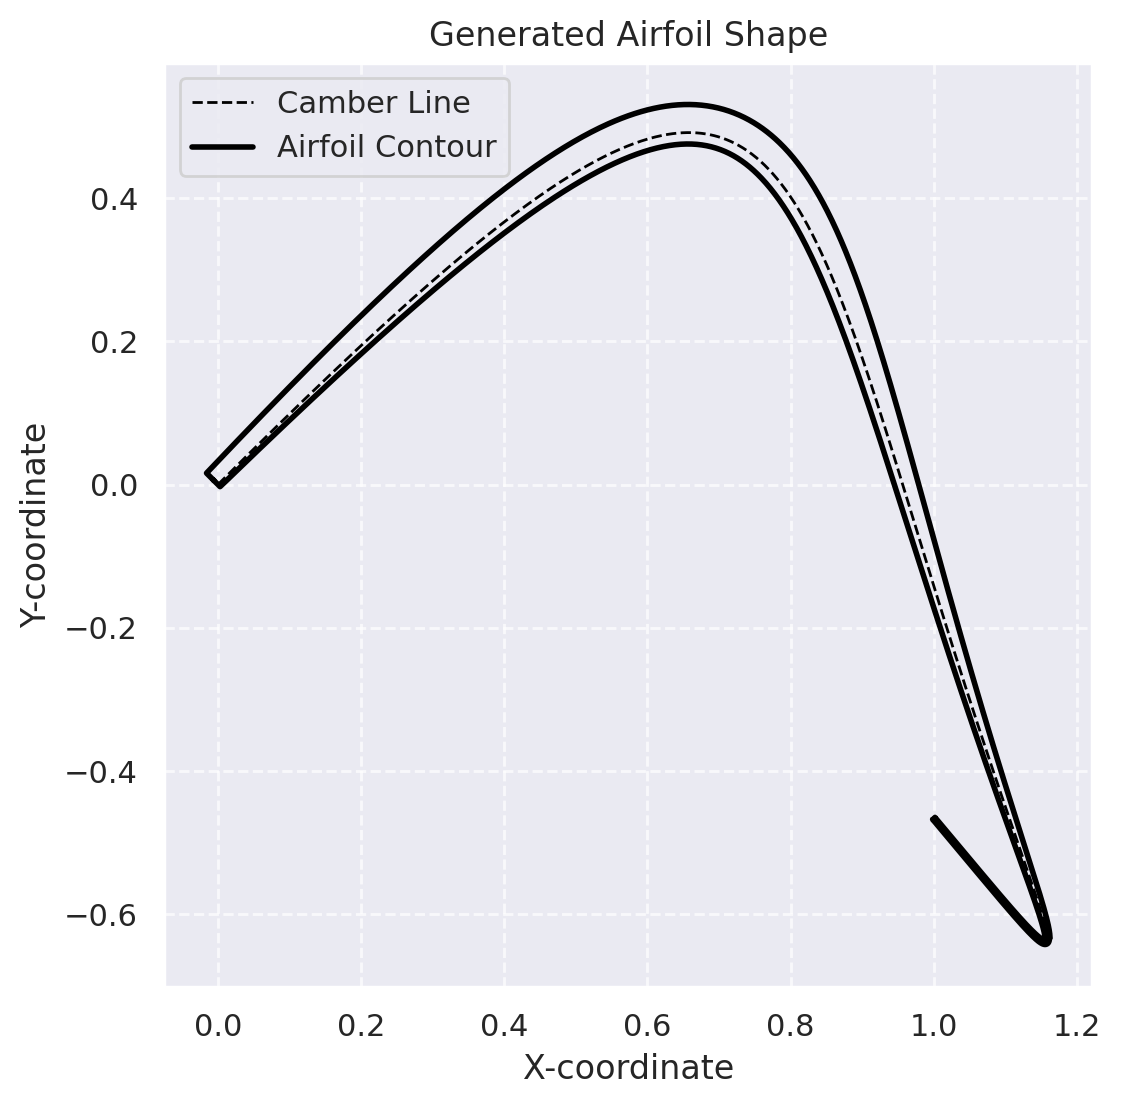

Episode 50, Reward: 1.6729, Actor Loss: 9.3923, Critic Loss: 1.8169


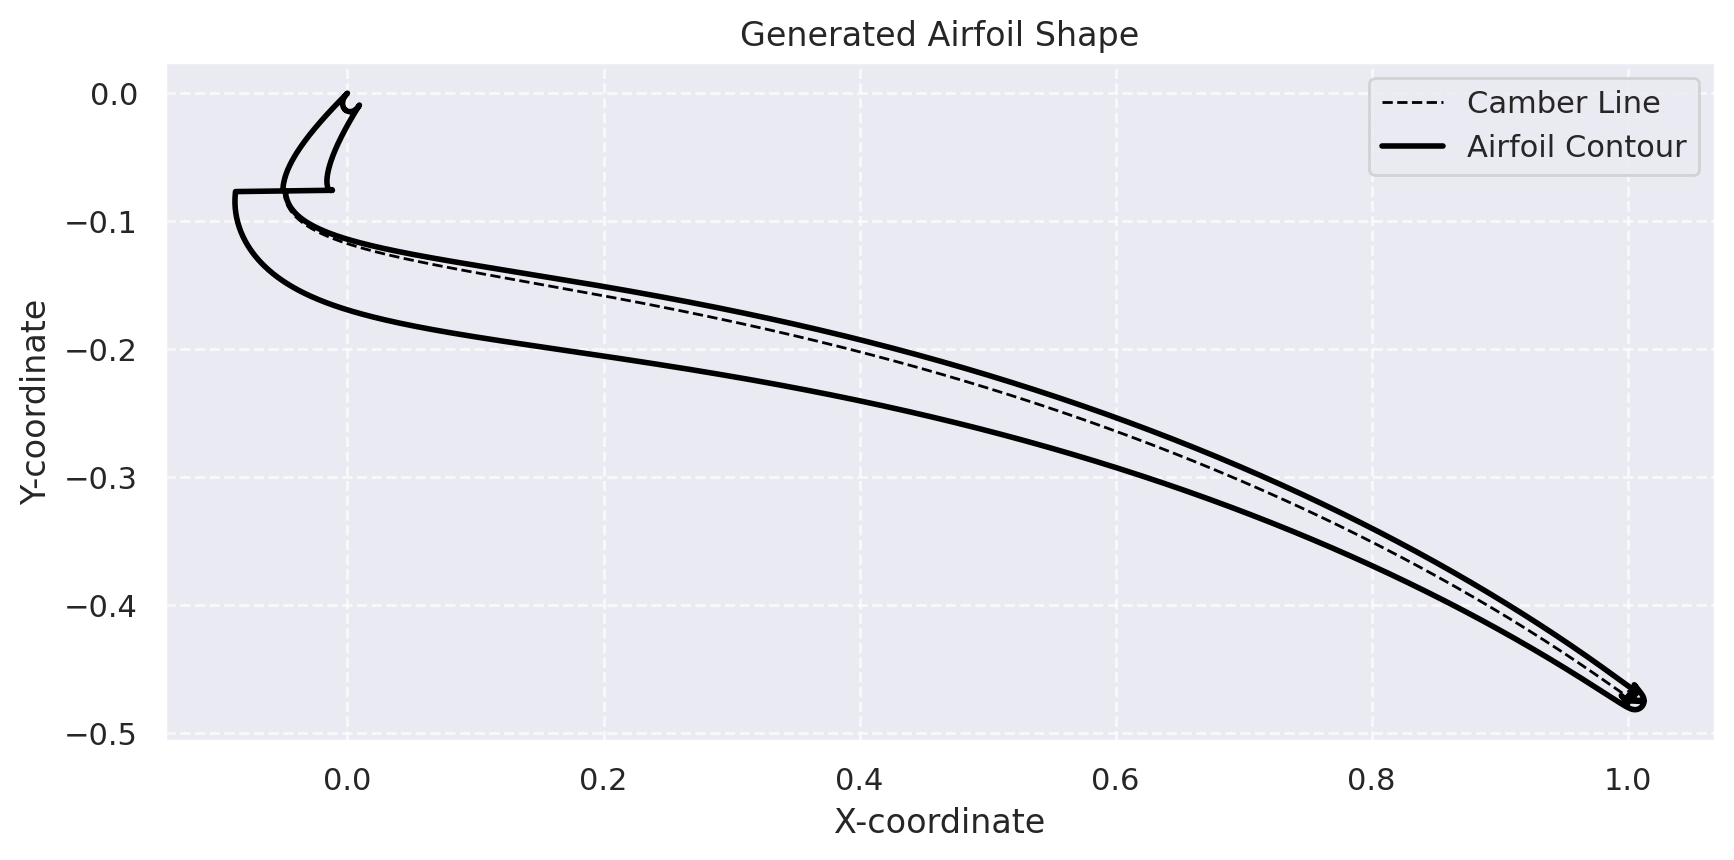

Episode 100, Reward: 1.7025, Actor Loss: 5.3440, Critic Loss: 1.8163


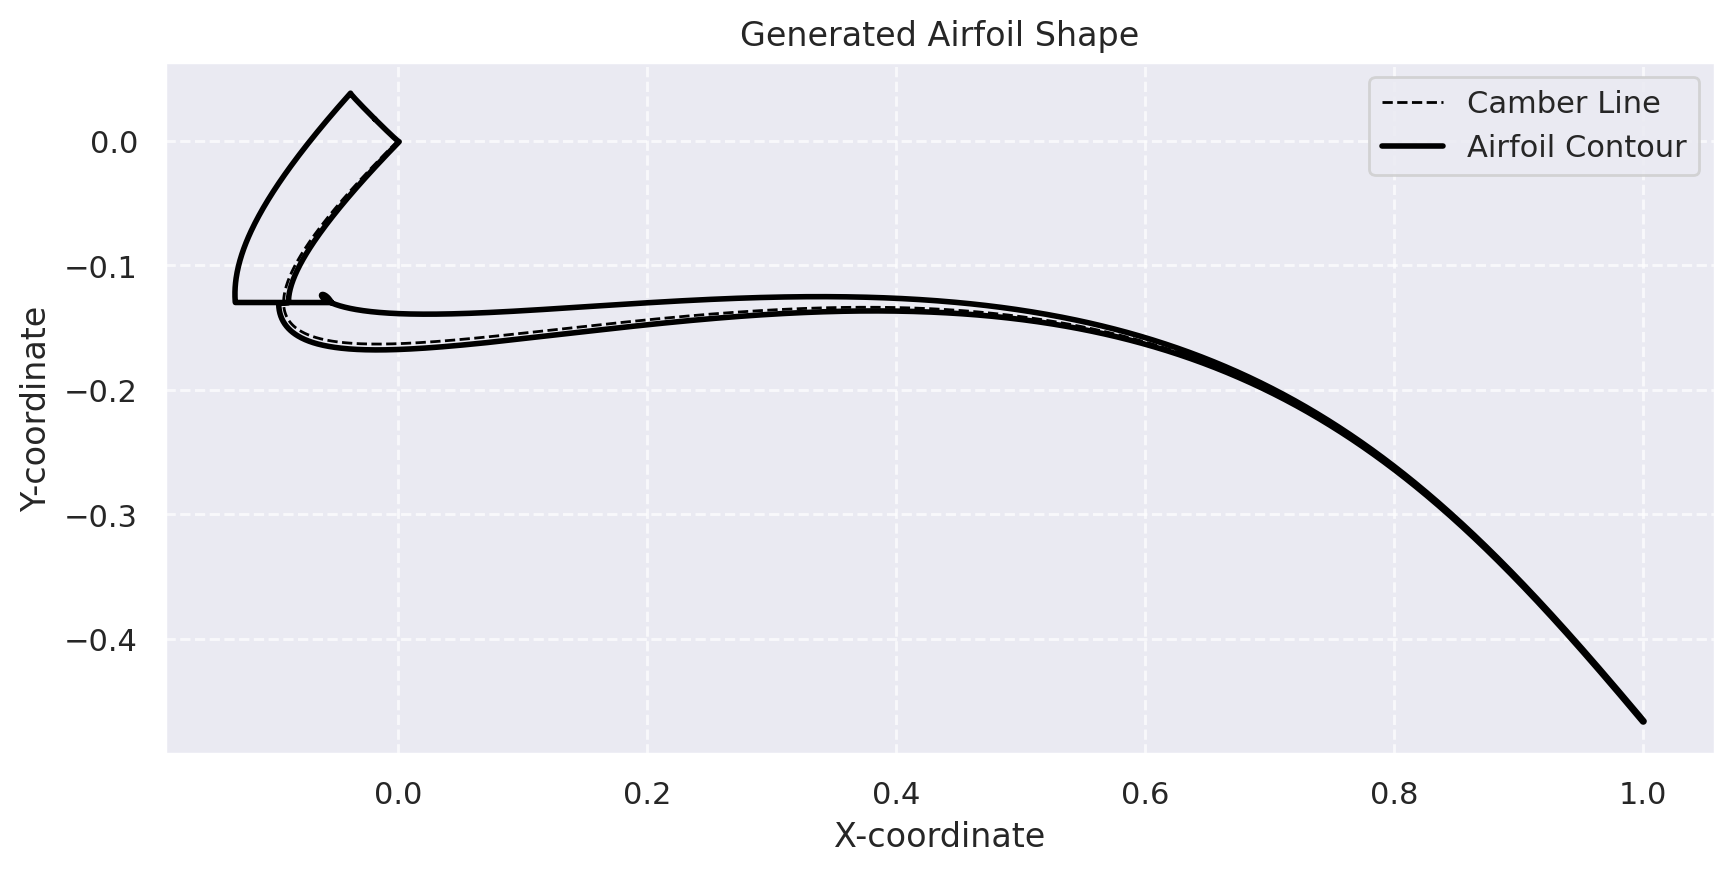

Episode 150, Reward: 1.6653, Actor Loss: 5.3848, Critic Loss: 1.1071


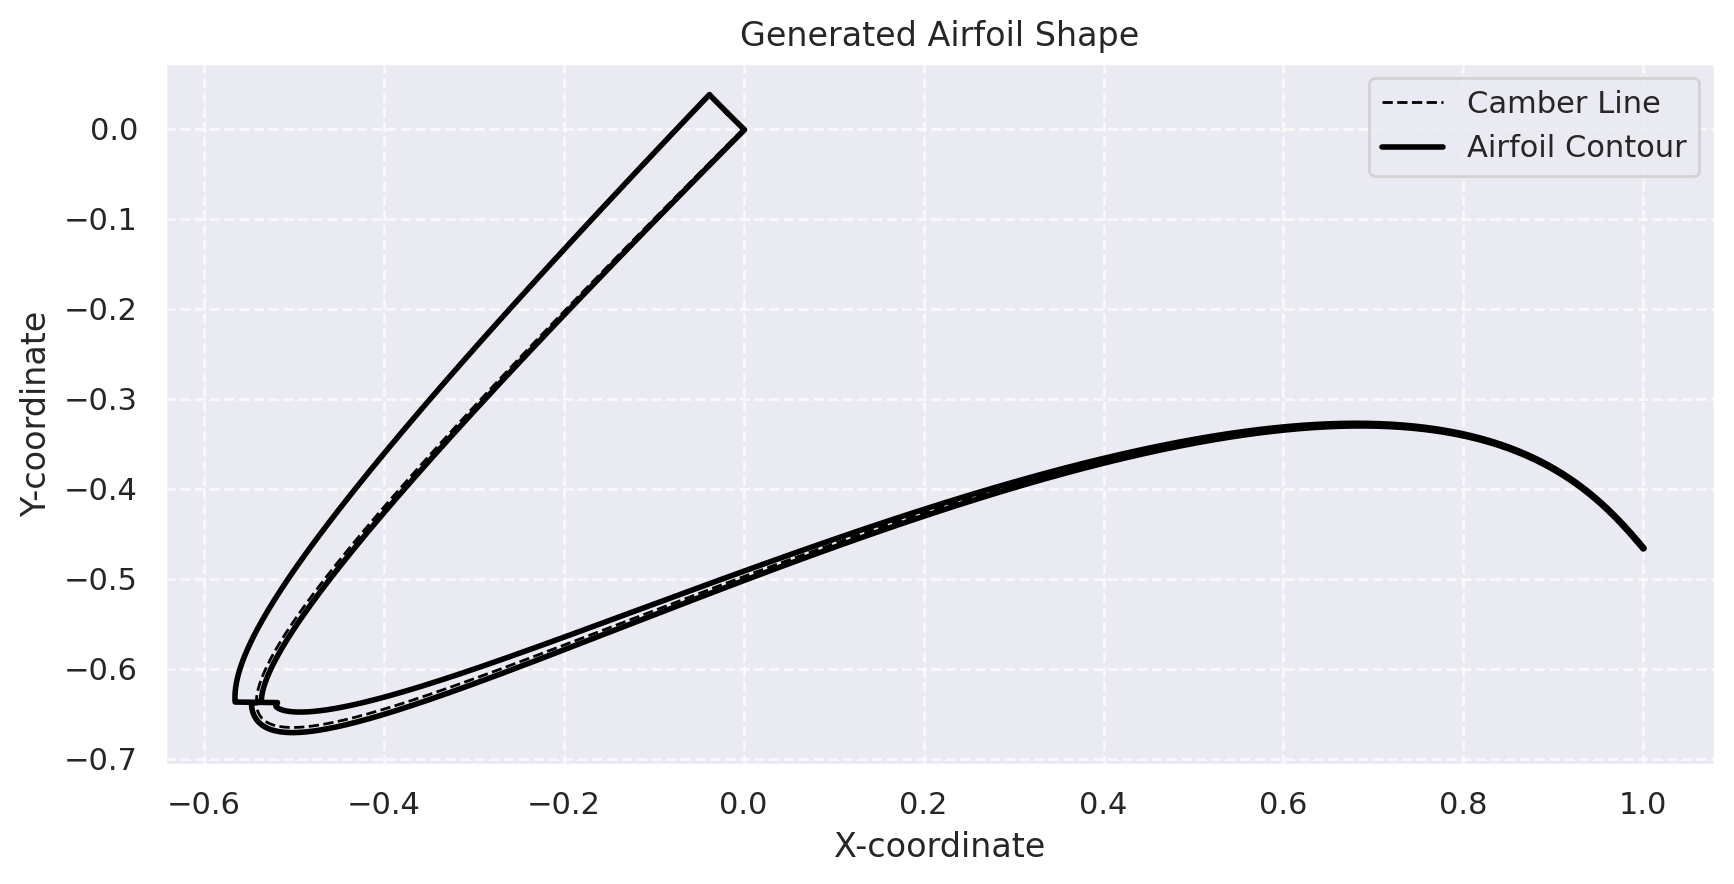

Episode 200, Reward: 1.6681, Actor Loss: 4.1829, Critic Loss: 0.7041


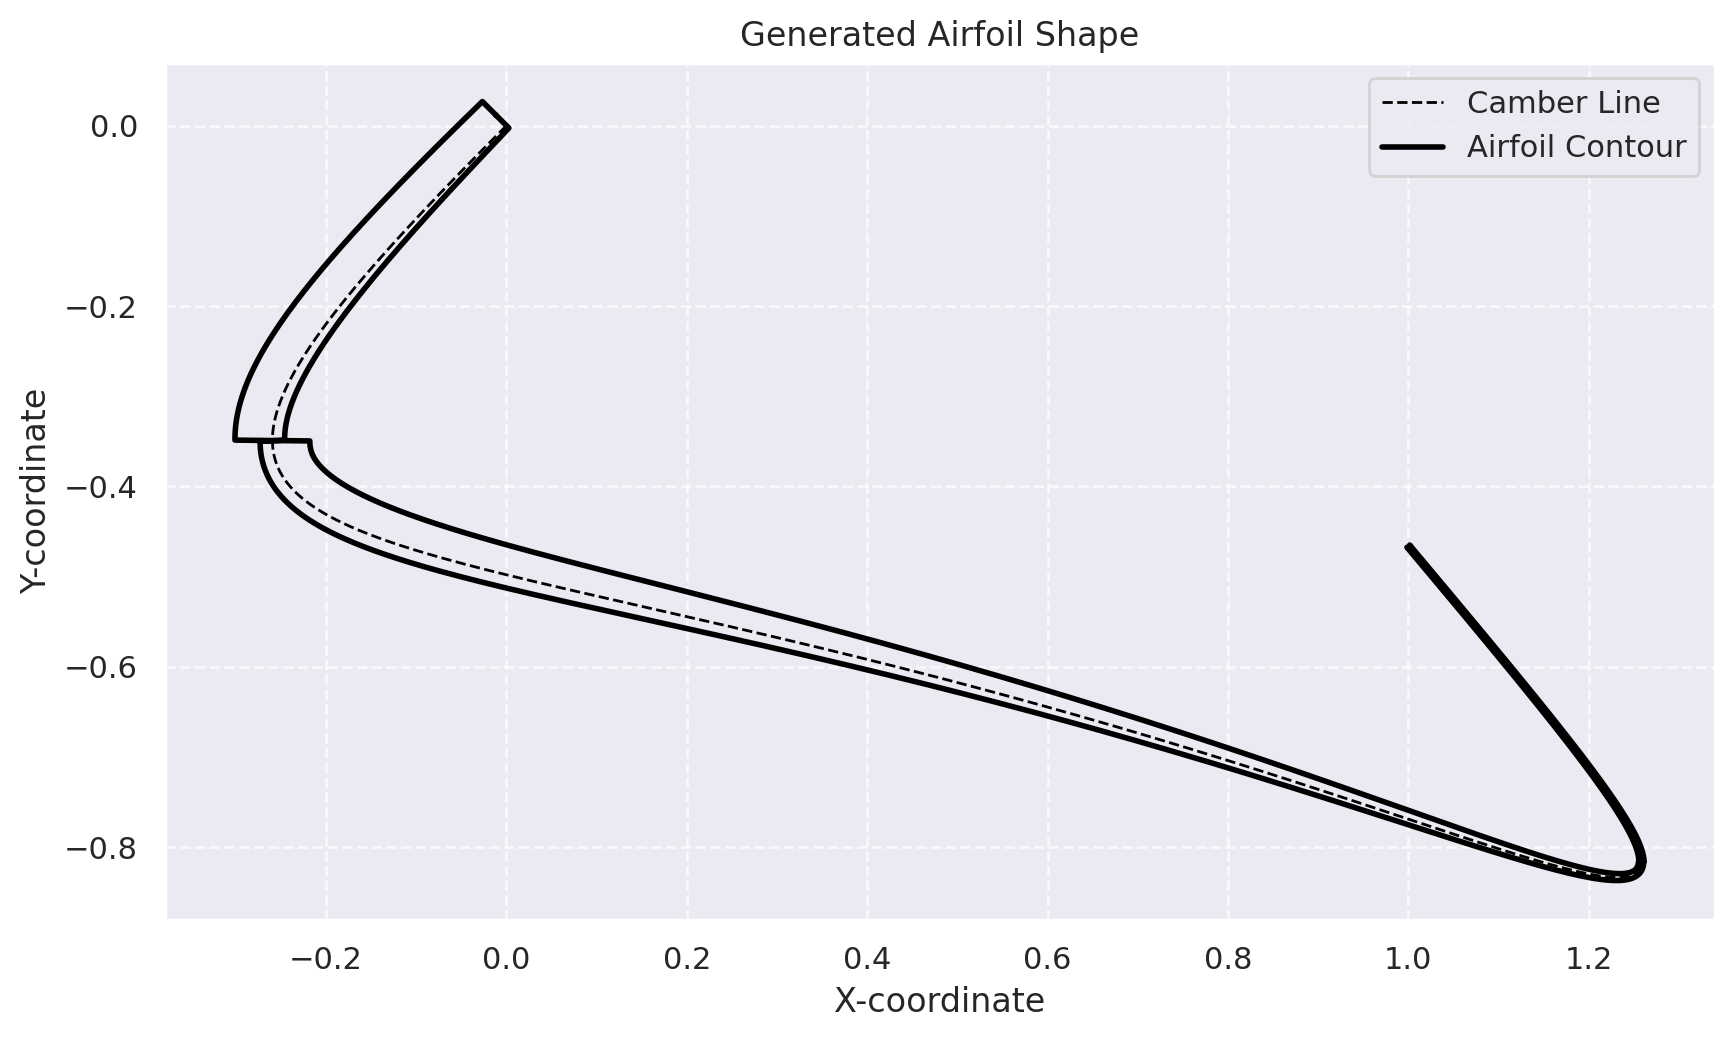

Episode 250, Reward: 1.6747, Actor Loss: 2.1464, Critic Loss: 0.2301


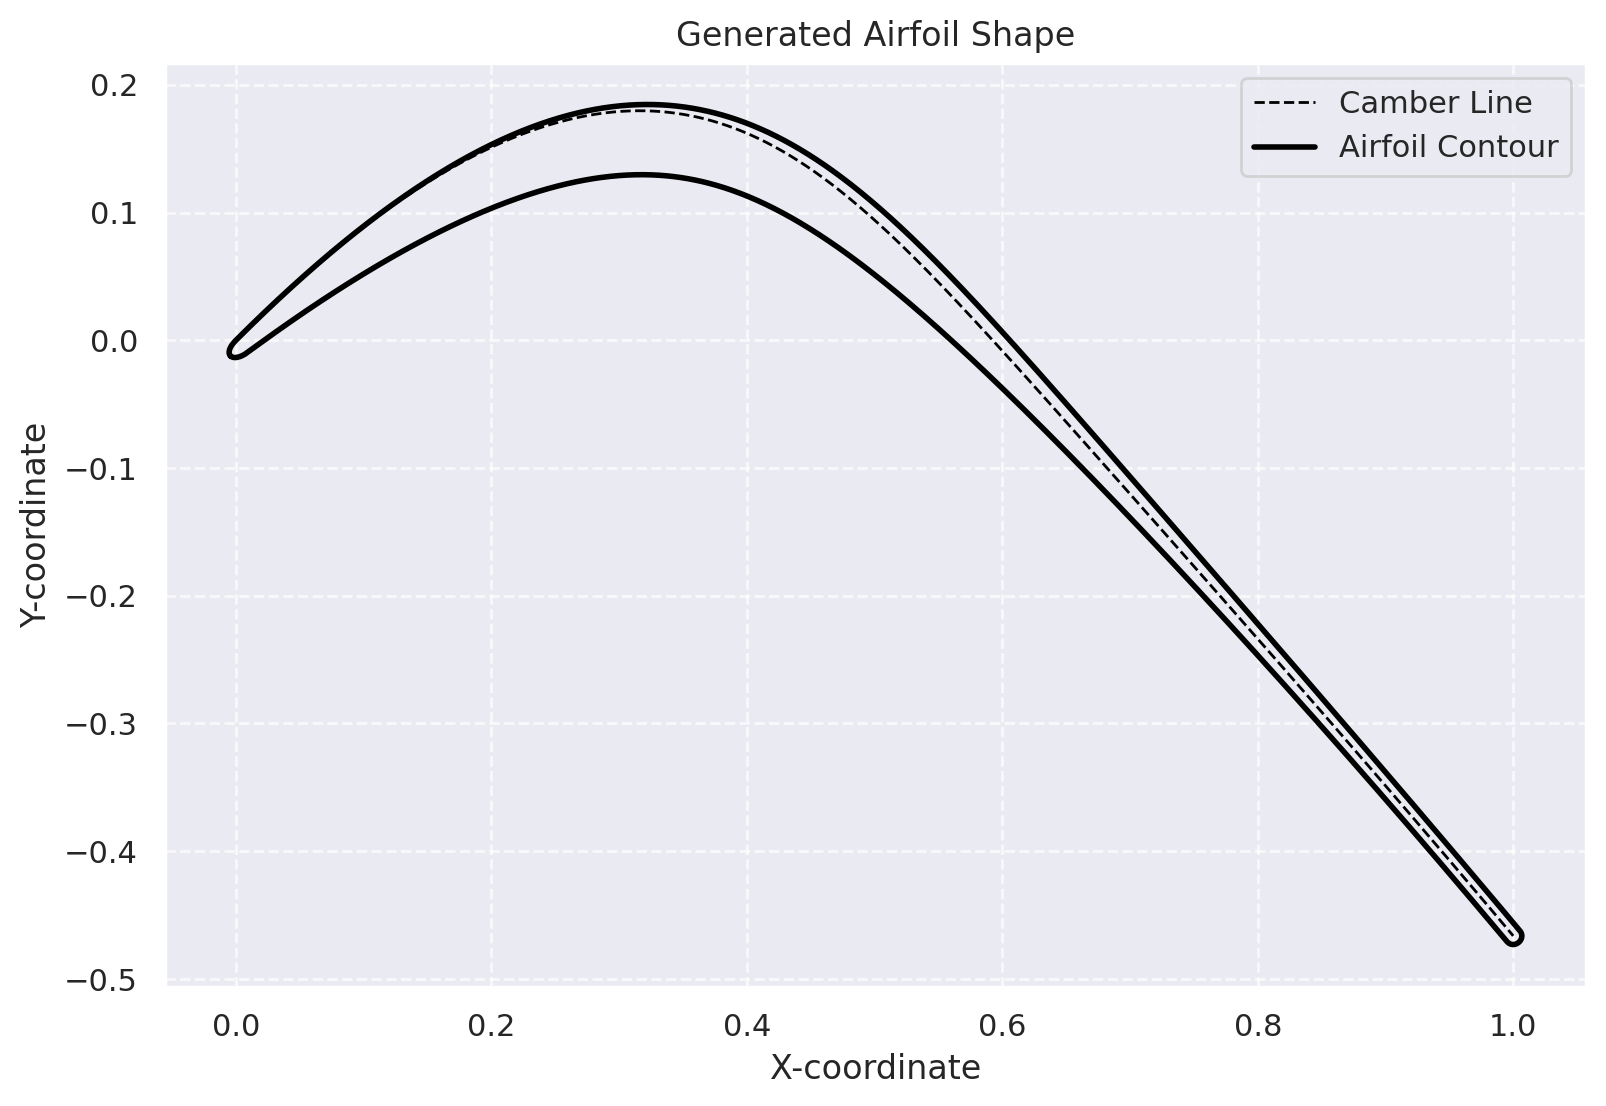

CasADi - 2025-08-20 14:14:53 WARNING("solver:nlp_grad_f failed: NaN detected for output grad_f_x, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-08-20 14:14:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 34, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-08-20 14:14:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 34, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-08-20 14:14:53 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 34, col 0).") [.../casadi/core/oracle_function.cpp:408]


Episode 300, Reward: 1.6770, Actor Loss: 0.5881, Critic Loss: 0.0139


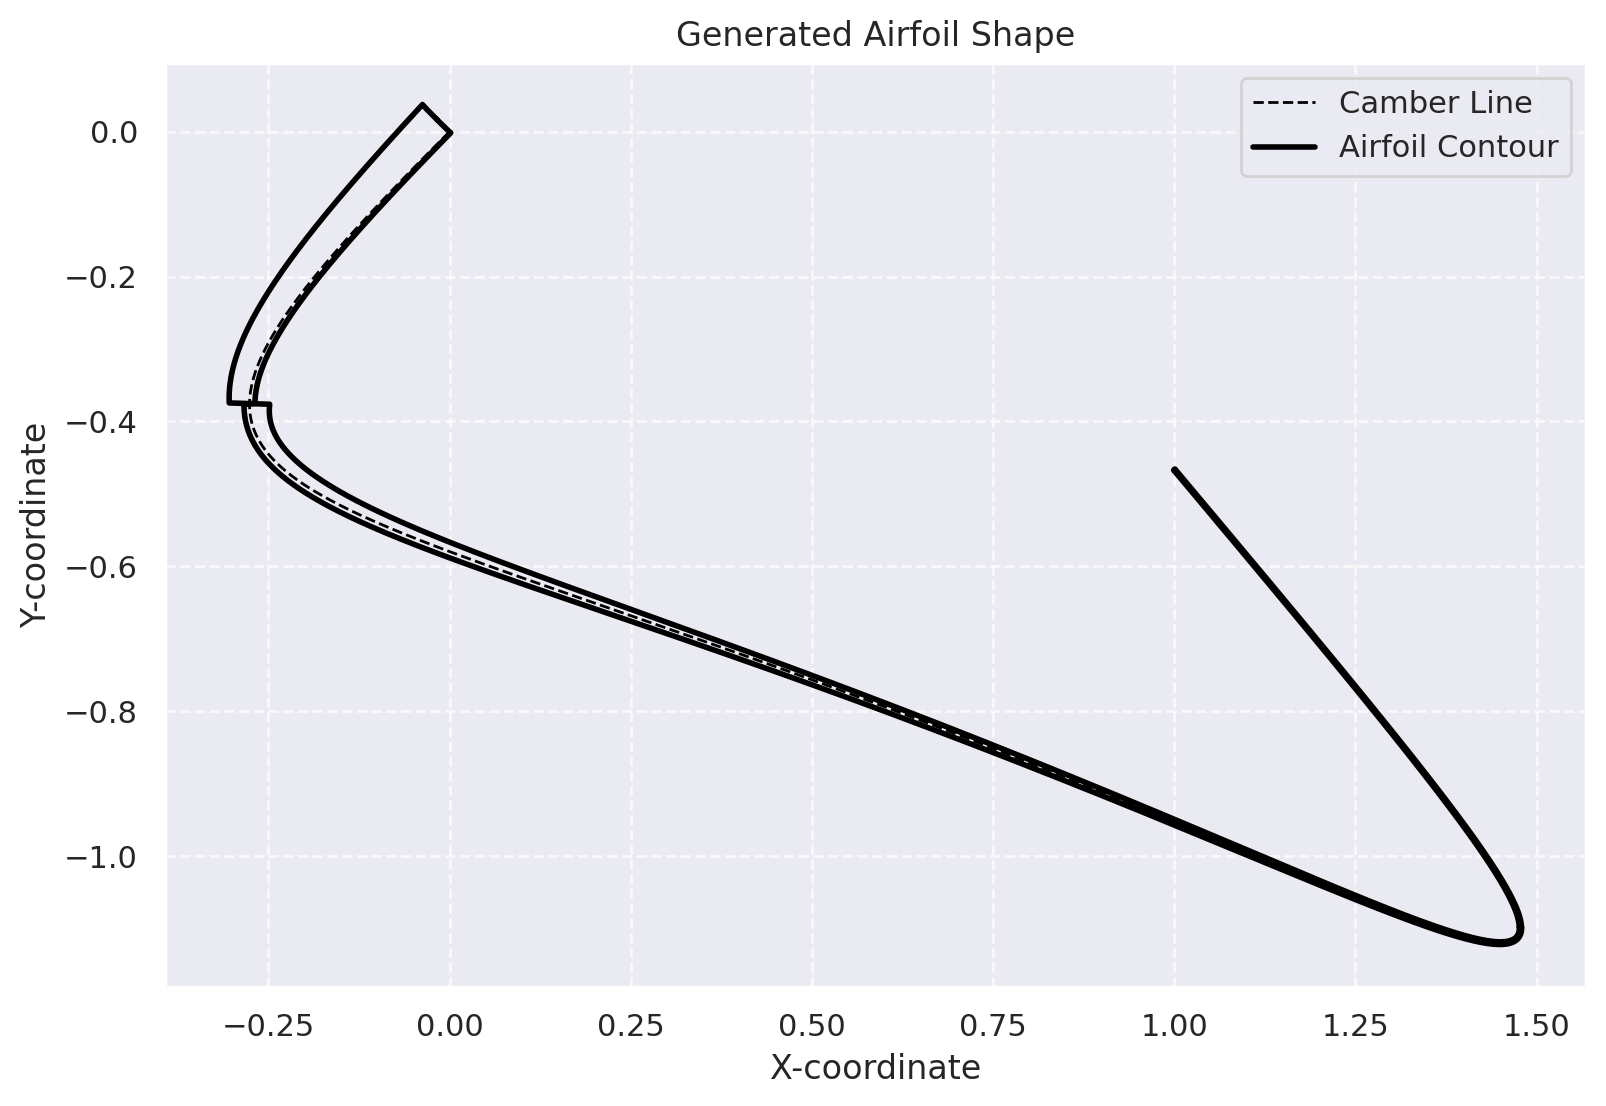

Episode 350, Reward: 1.6931, Actor Loss: -1.1430, Critic Loss: 0.0466


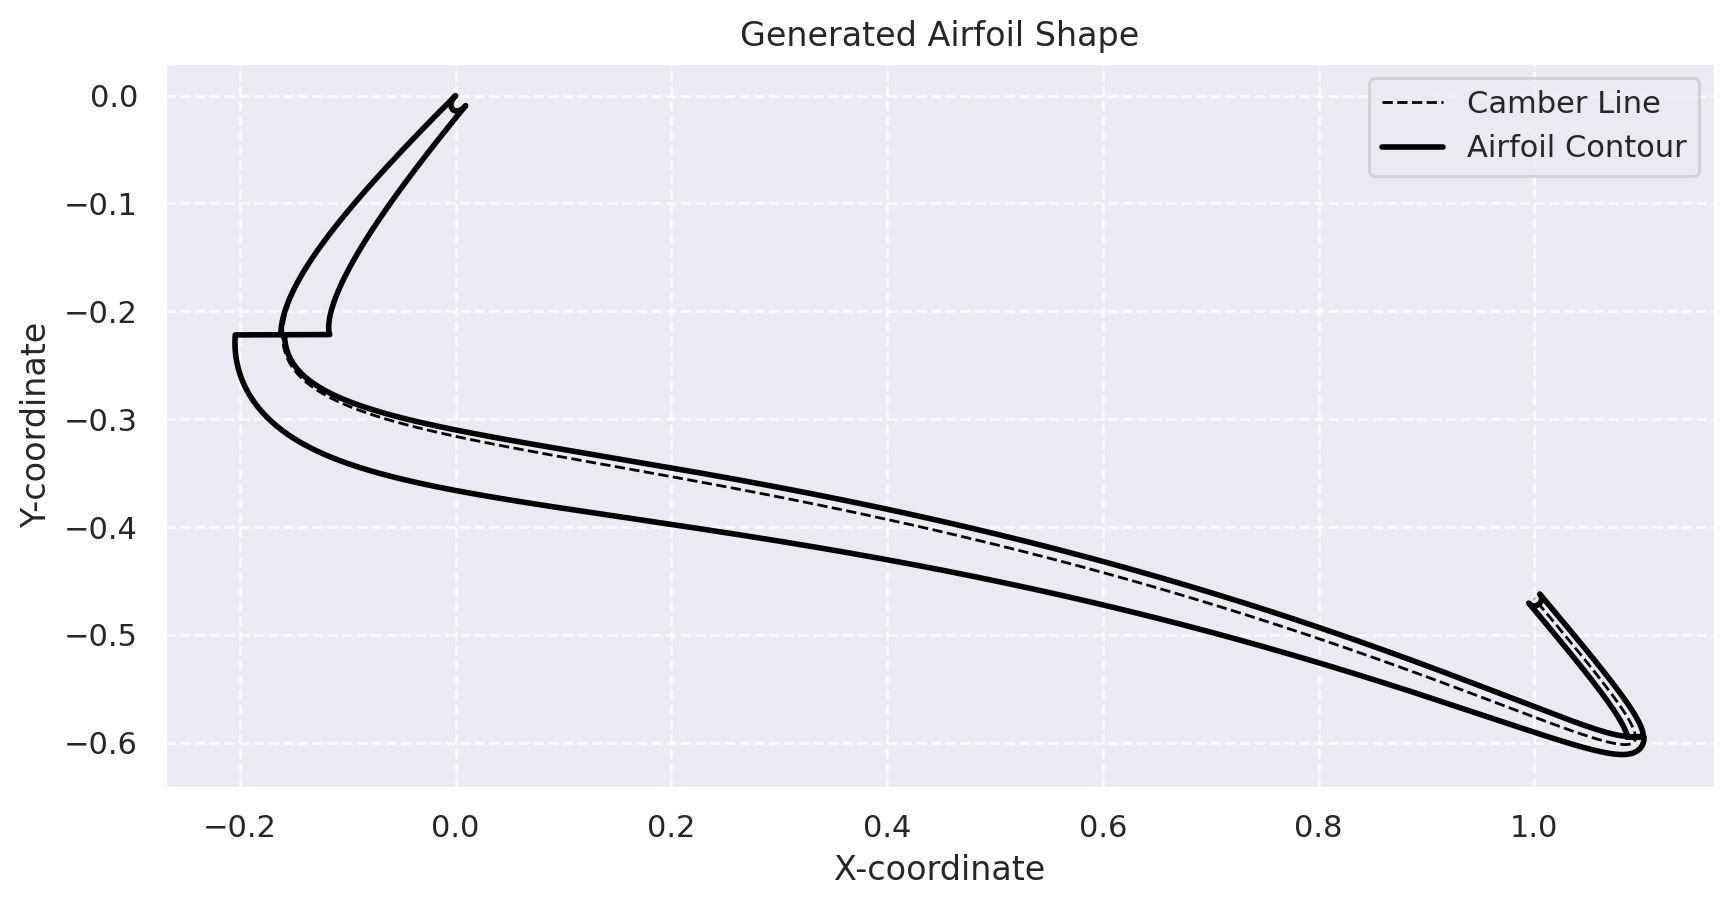

Episode 400, Reward: 1.6848, Actor Loss: 0.9858, Critic Loss: 0.0659


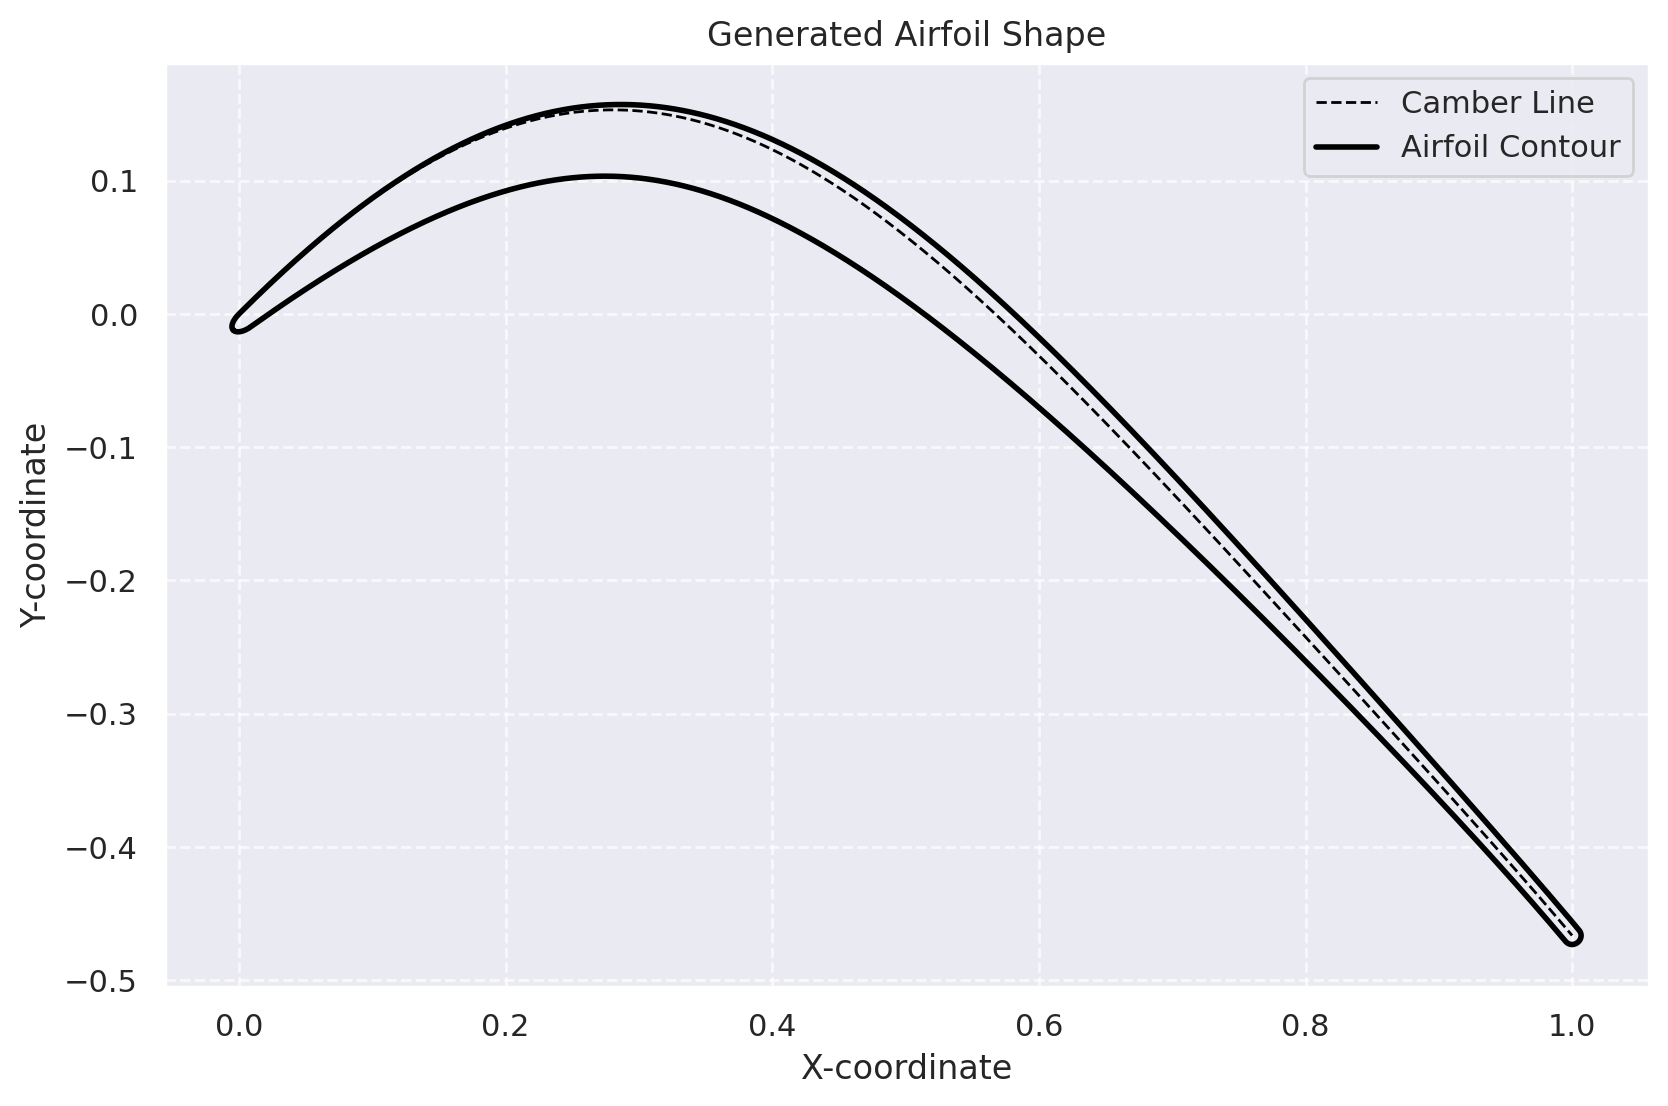

Episode 450, Reward: 1.6721, Actor Loss: 1.6343, Critic Loss: 0.1275


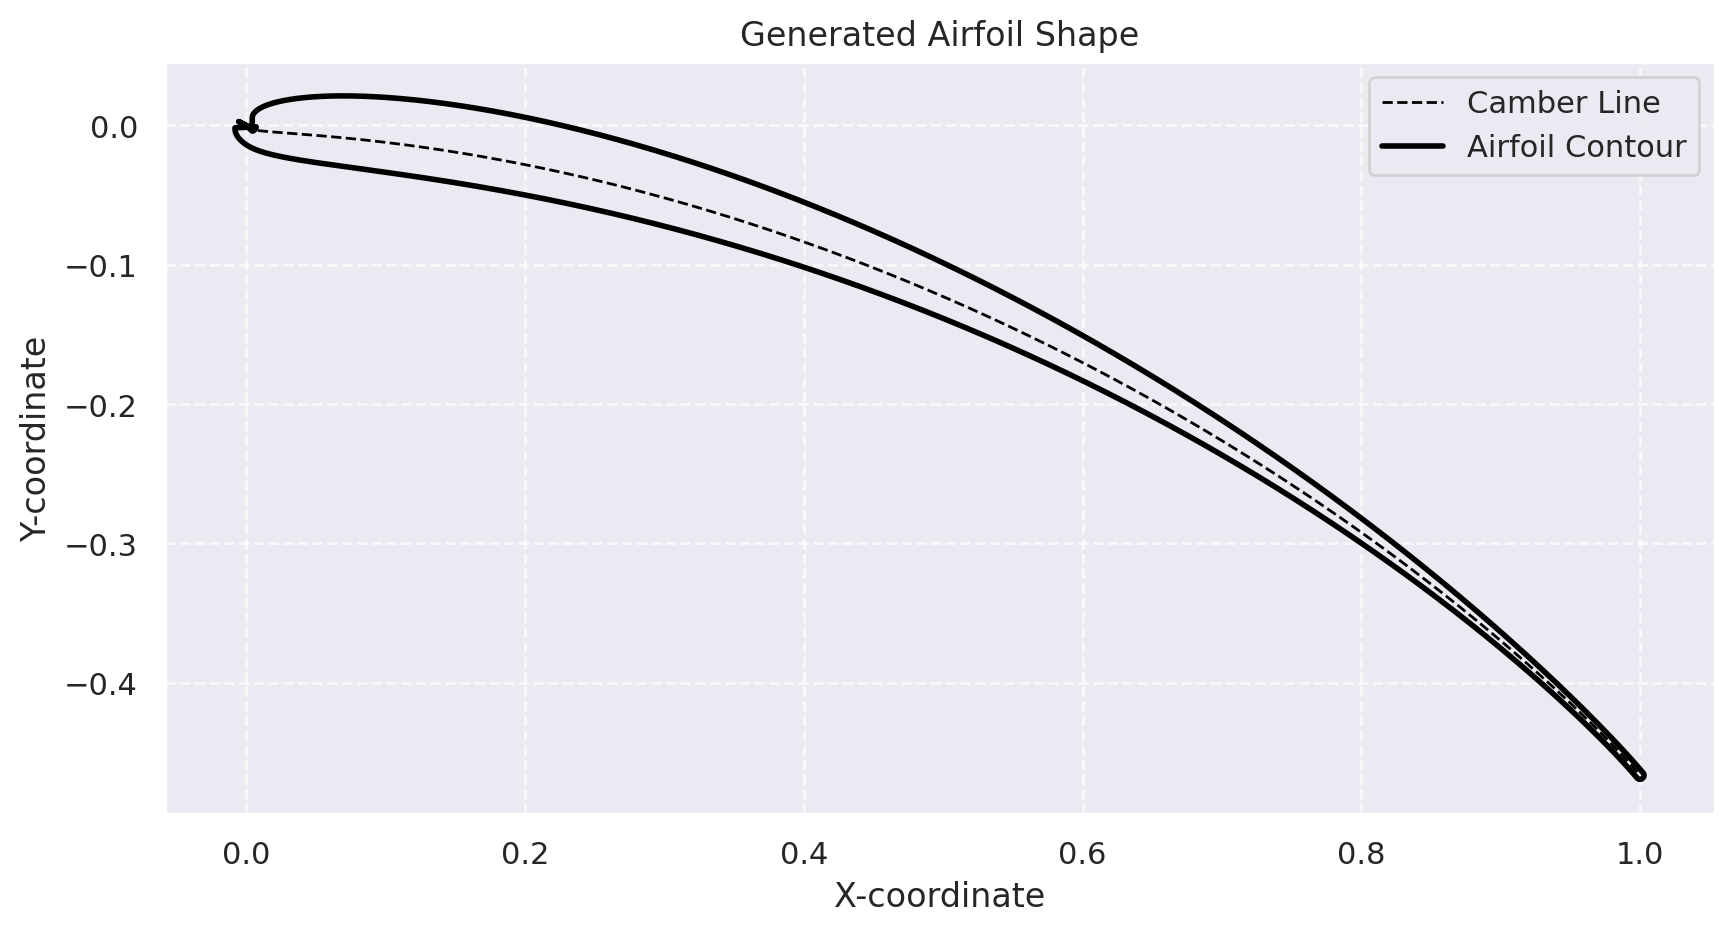

Episode 500, Reward: 1.7280, Actor Loss: -0.3030, Critic Loss: 0.0032


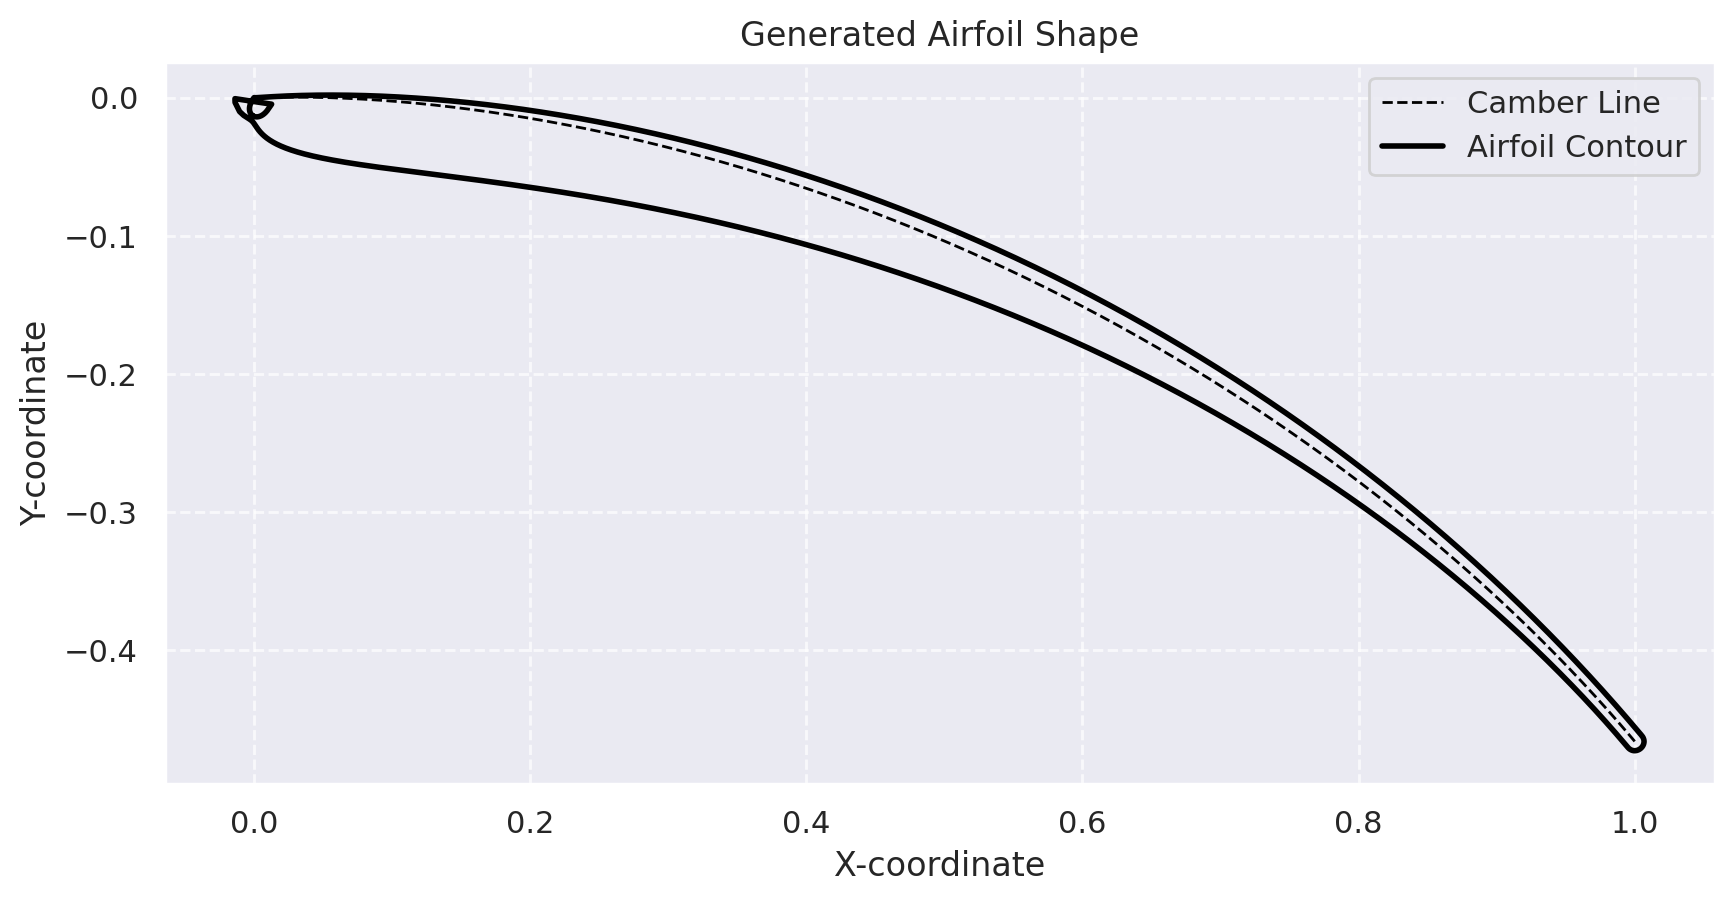

Episode 550, Reward: 1.6840, Actor Loss: 0.7533, Critic Loss: 0.0261


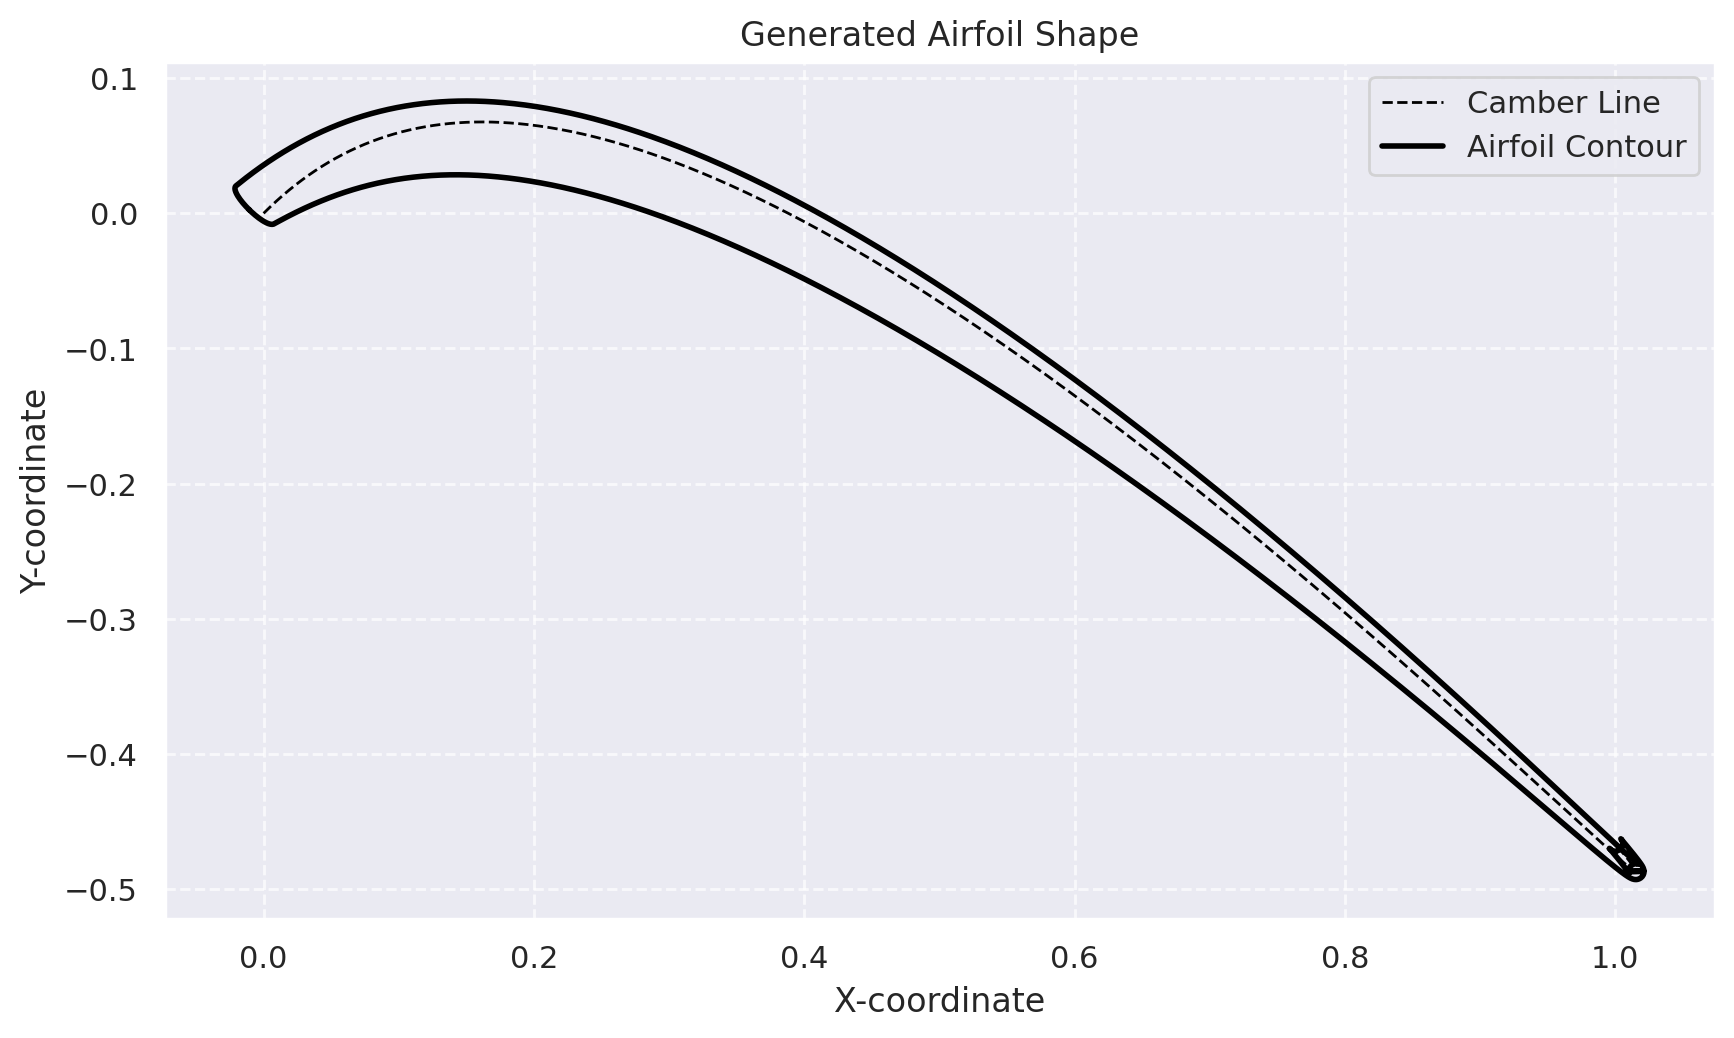

Episode 600, Reward: 1.7114, Actor Loss: 0.0887, Critic Loss: 0.0004


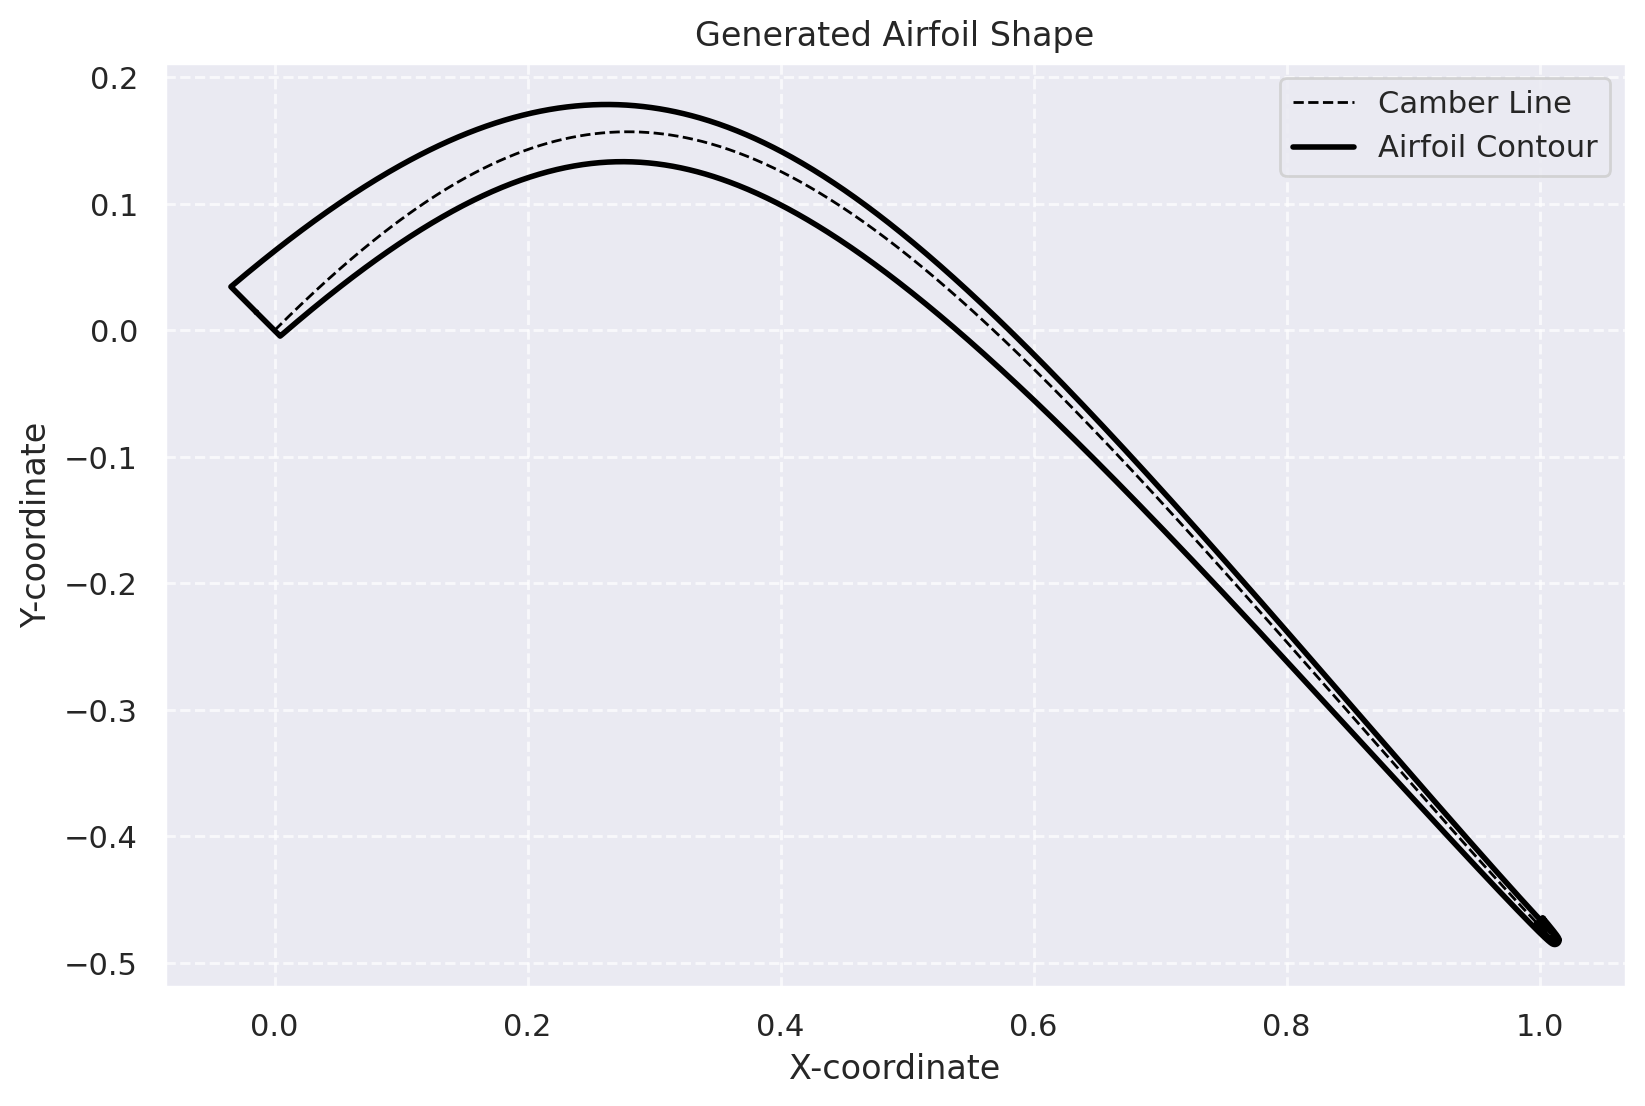

Episode 650, Reward: 1.6711, Actor Loss: -1.1522, Critic Loss: 0.0475


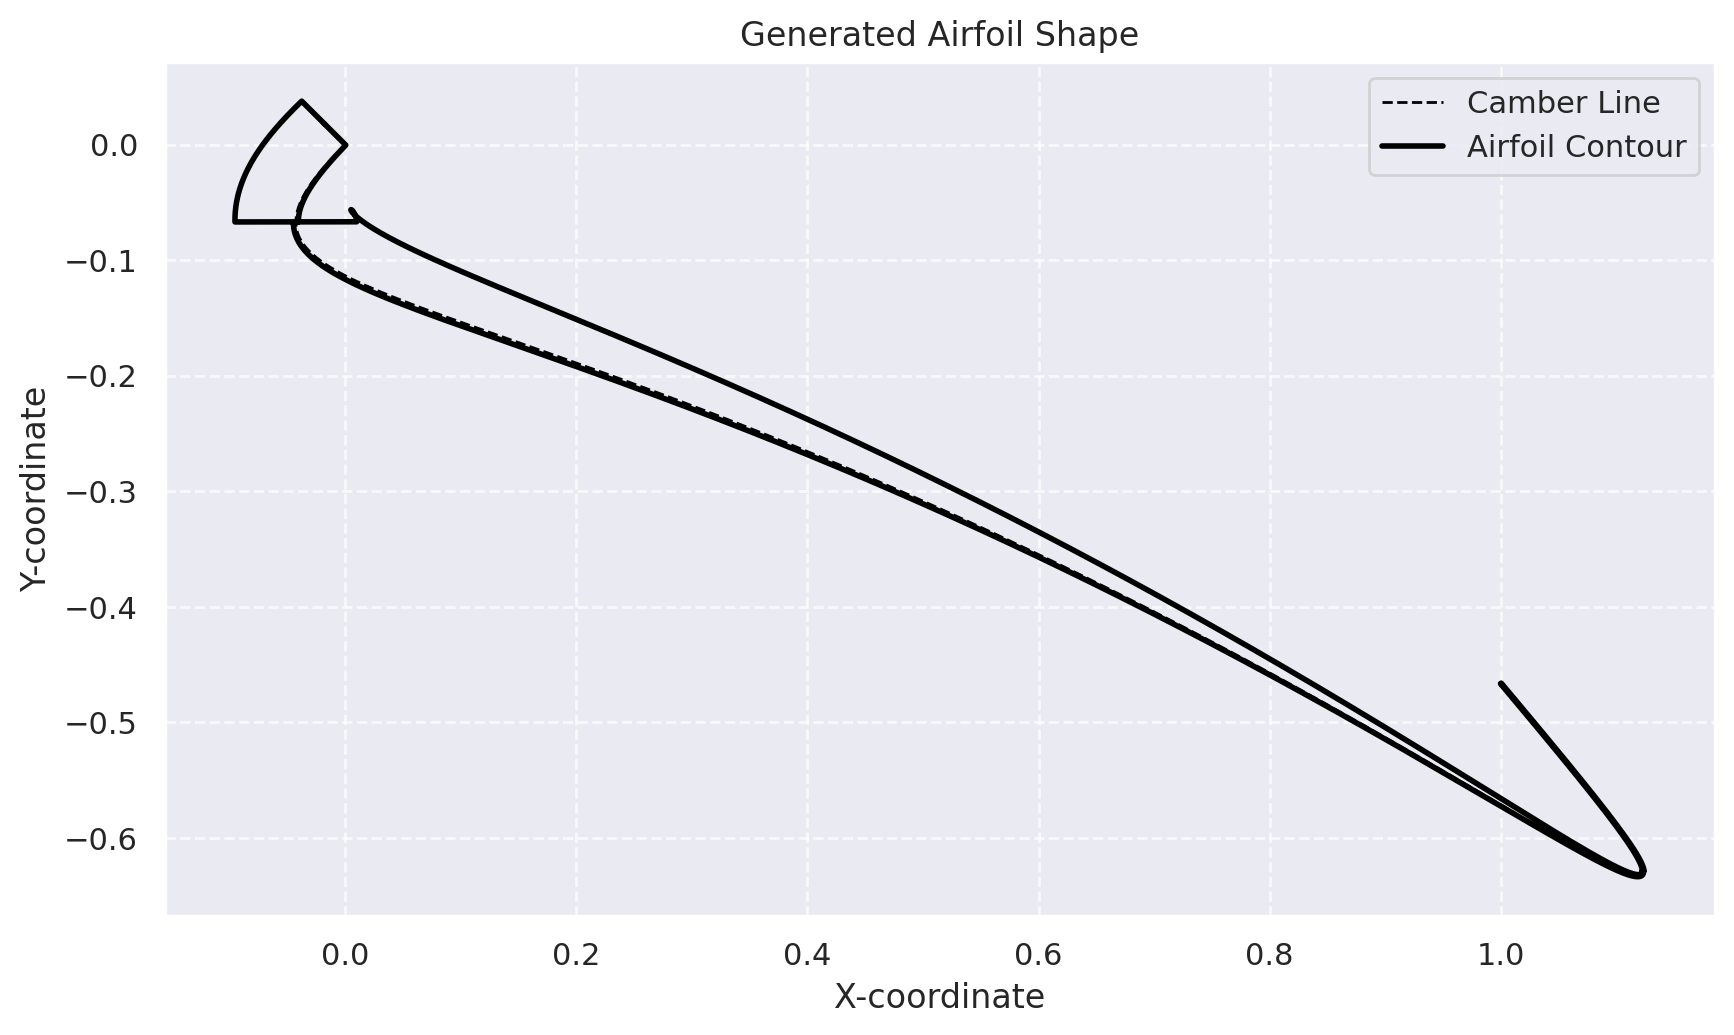

Episode 700, Reward: 1.6679, Actor Loss: 0.1313, Critic Loss: 0.0012


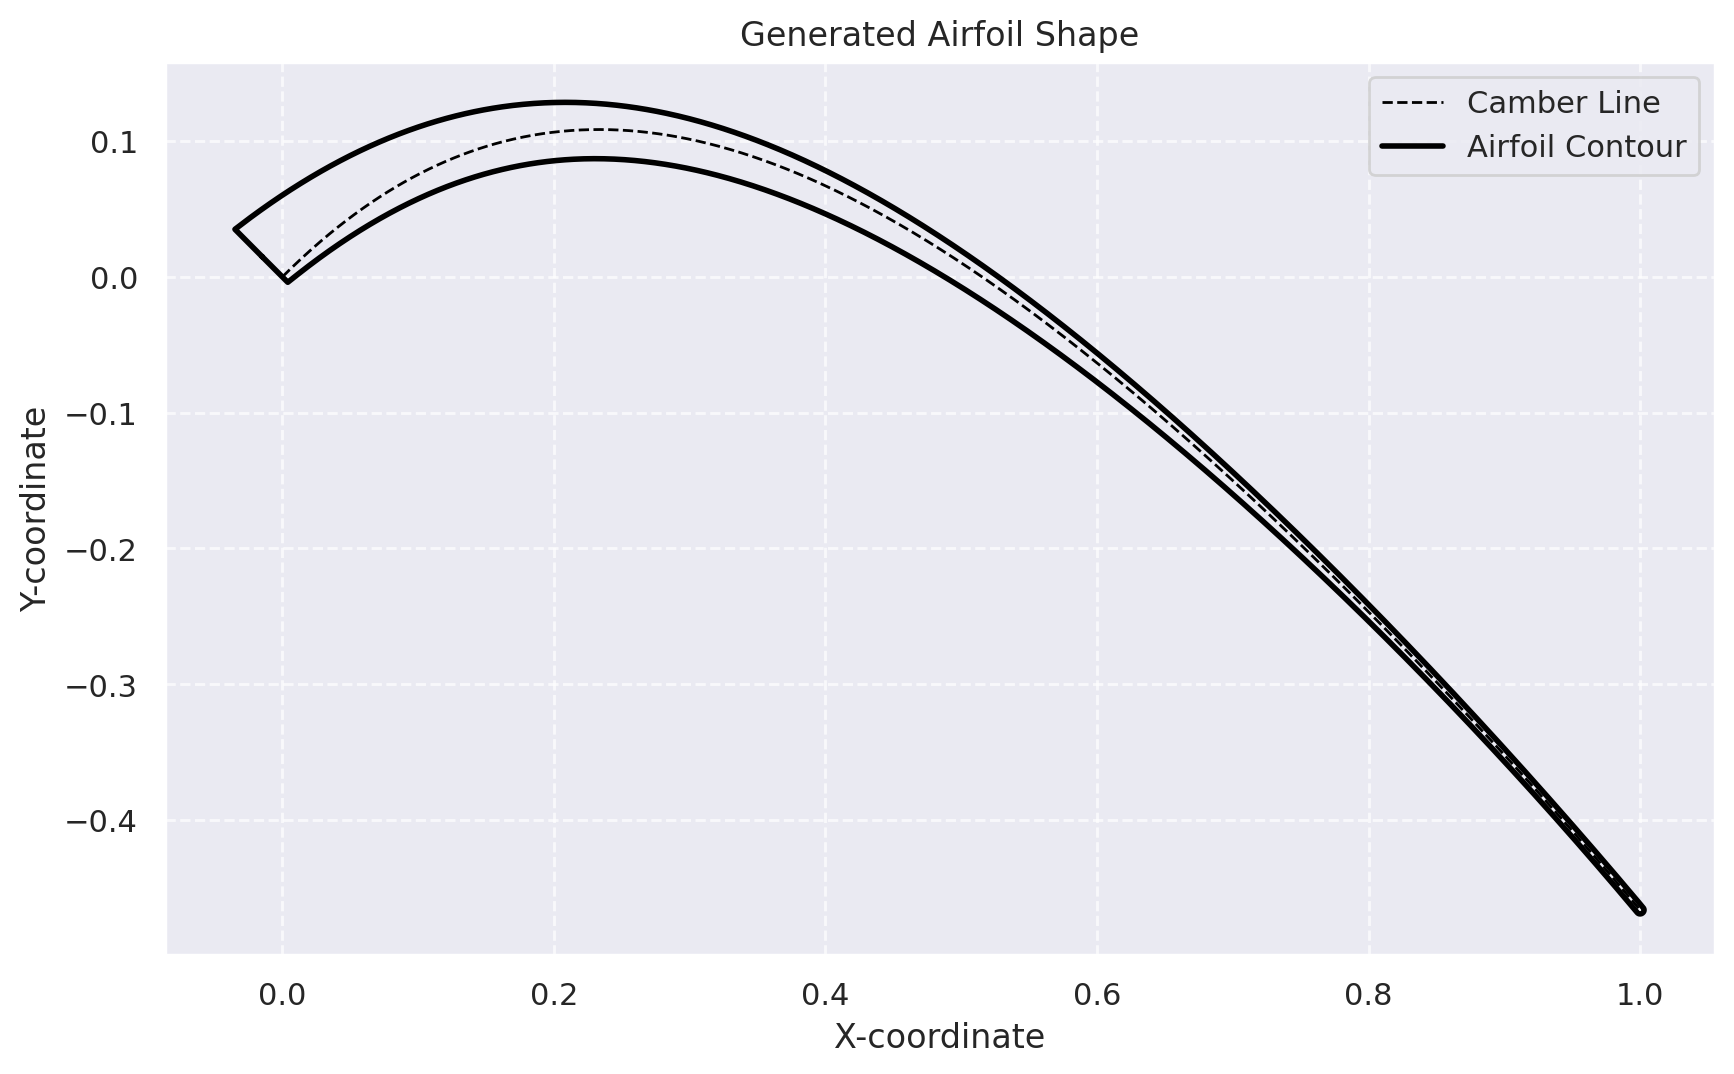

Episode 750, Reward: 1.6731, Actor Loss: 0.5398, Critic Loss: 0.0348


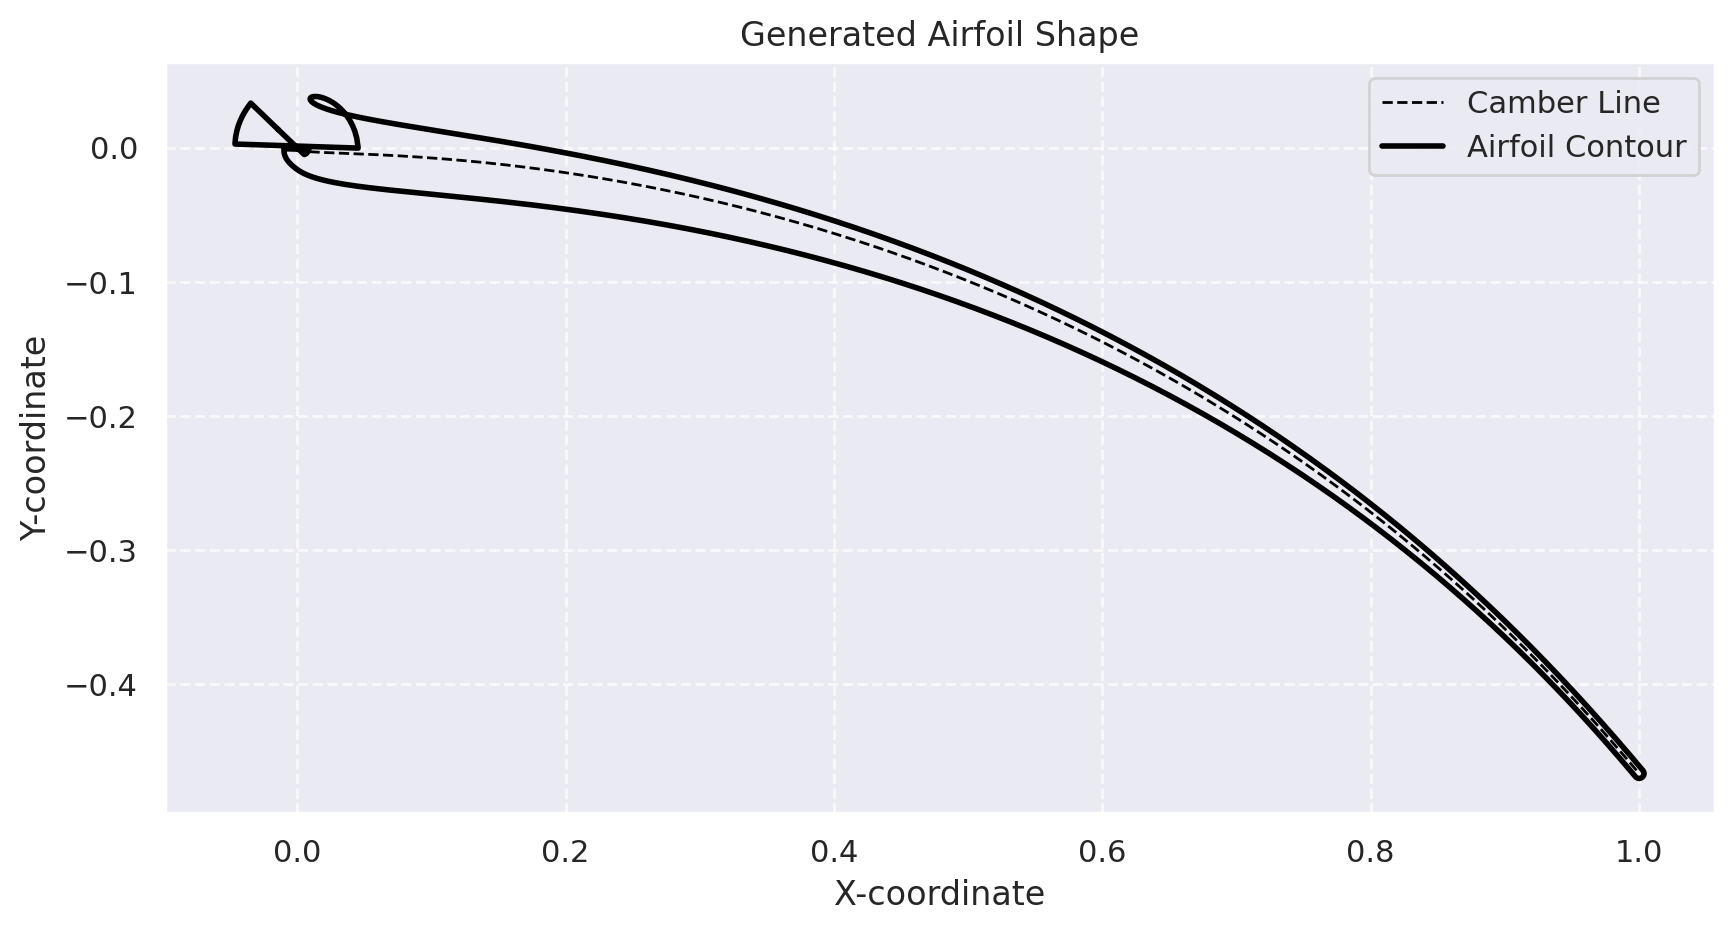

Episode 800, Reward: 1.6740, Actor Loss: -0.7102, Critic Loss: 0.0241


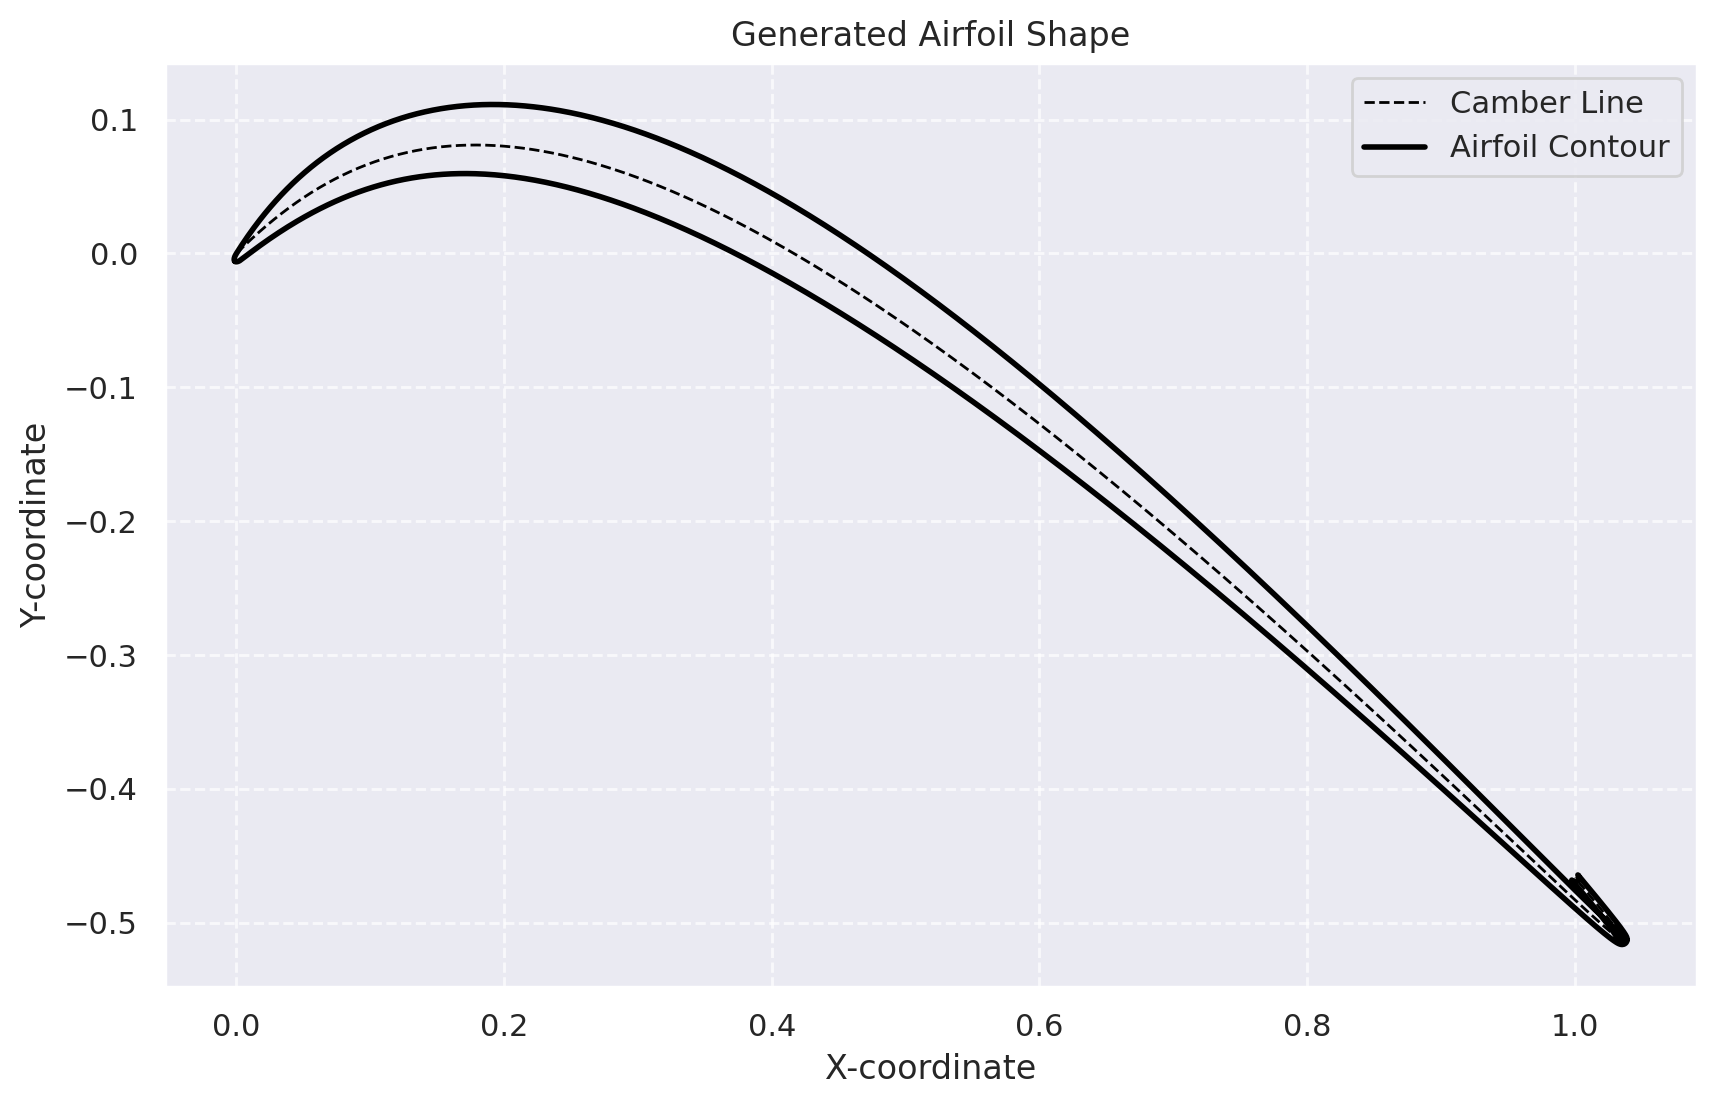

Episode 850, Reward: 1.6640, Actor Loss: 0.1947, Critic Loss: 0.0042


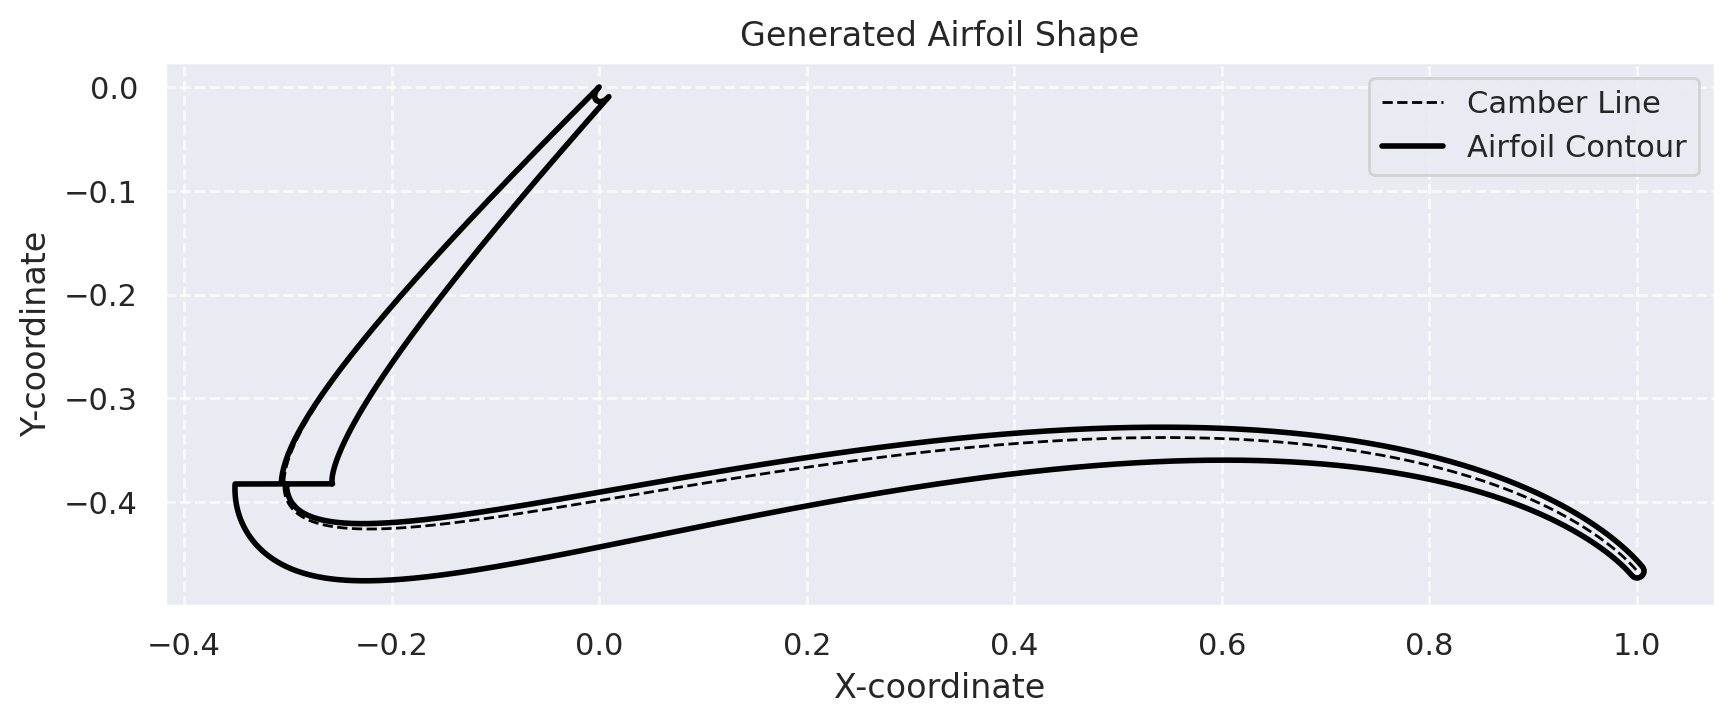

Episode 900, Reward: 1.6824, Actor Loss: 0.2969, Critic Loss: 0.0153


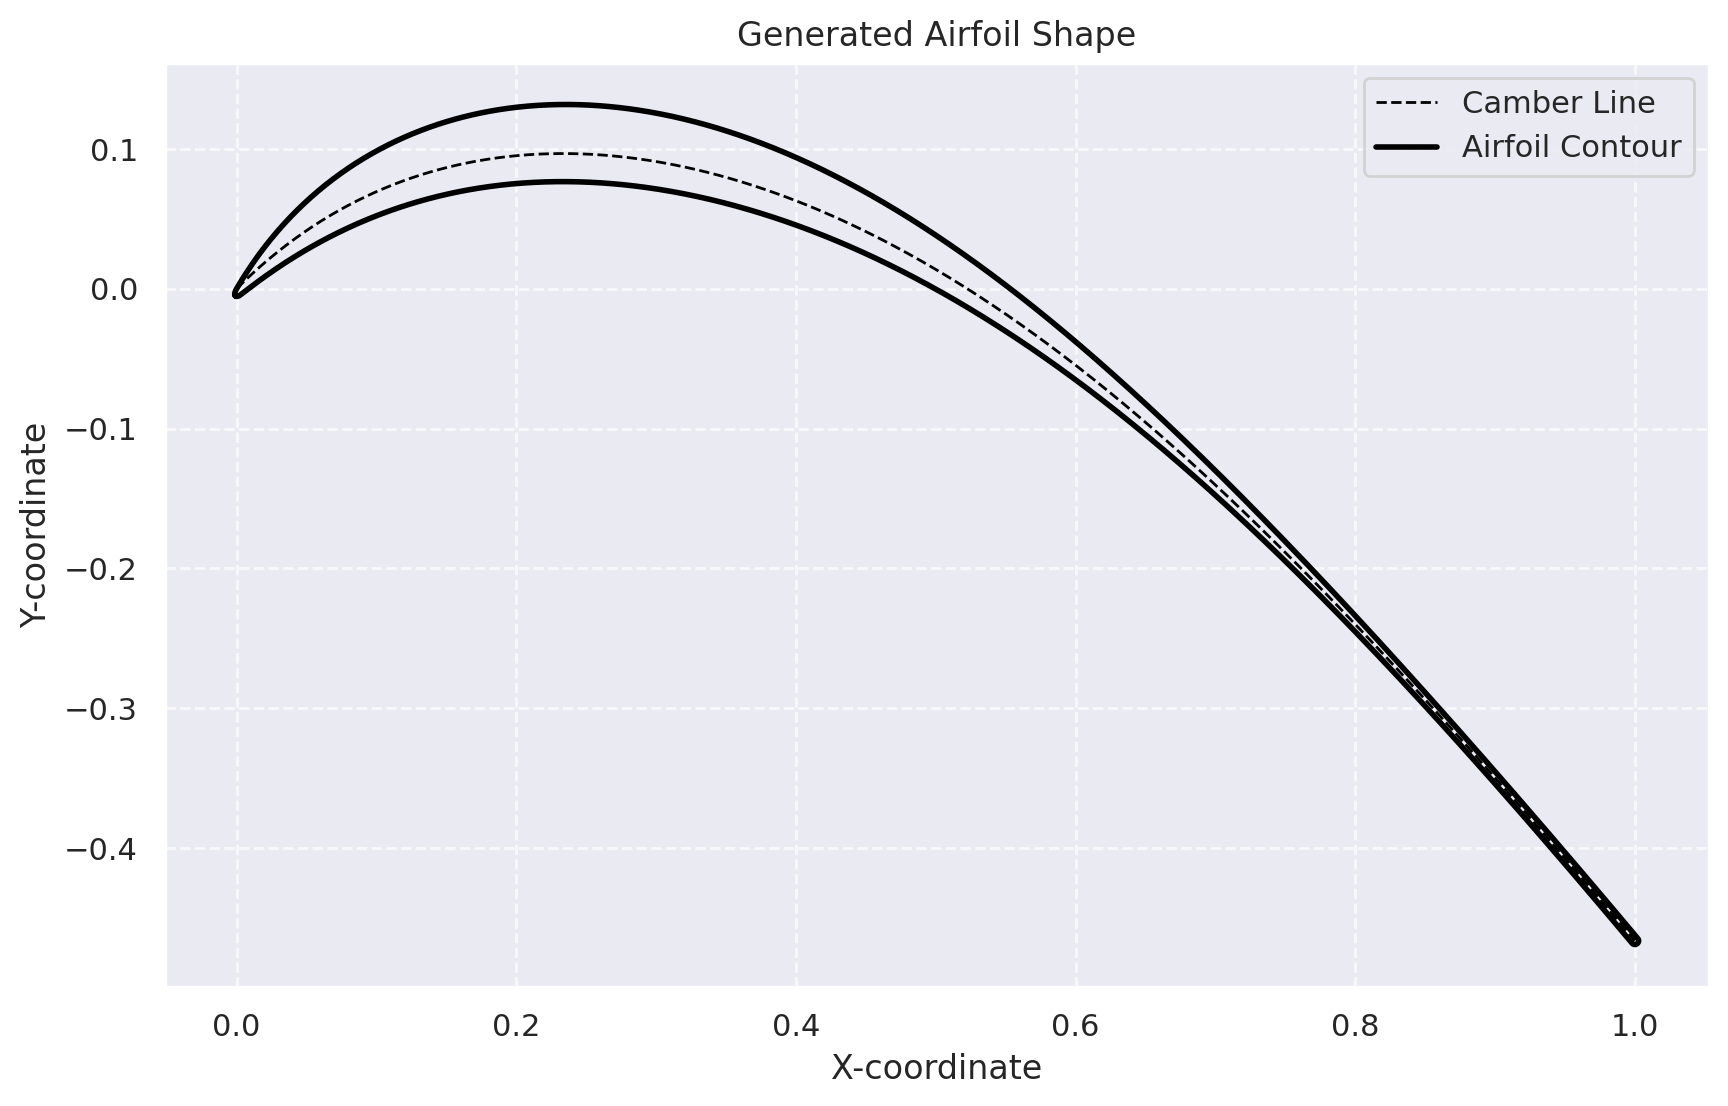

Episode 950, Reward: 1.6963, Actor Loss: -0.3267, Critic Loss: 0.0056


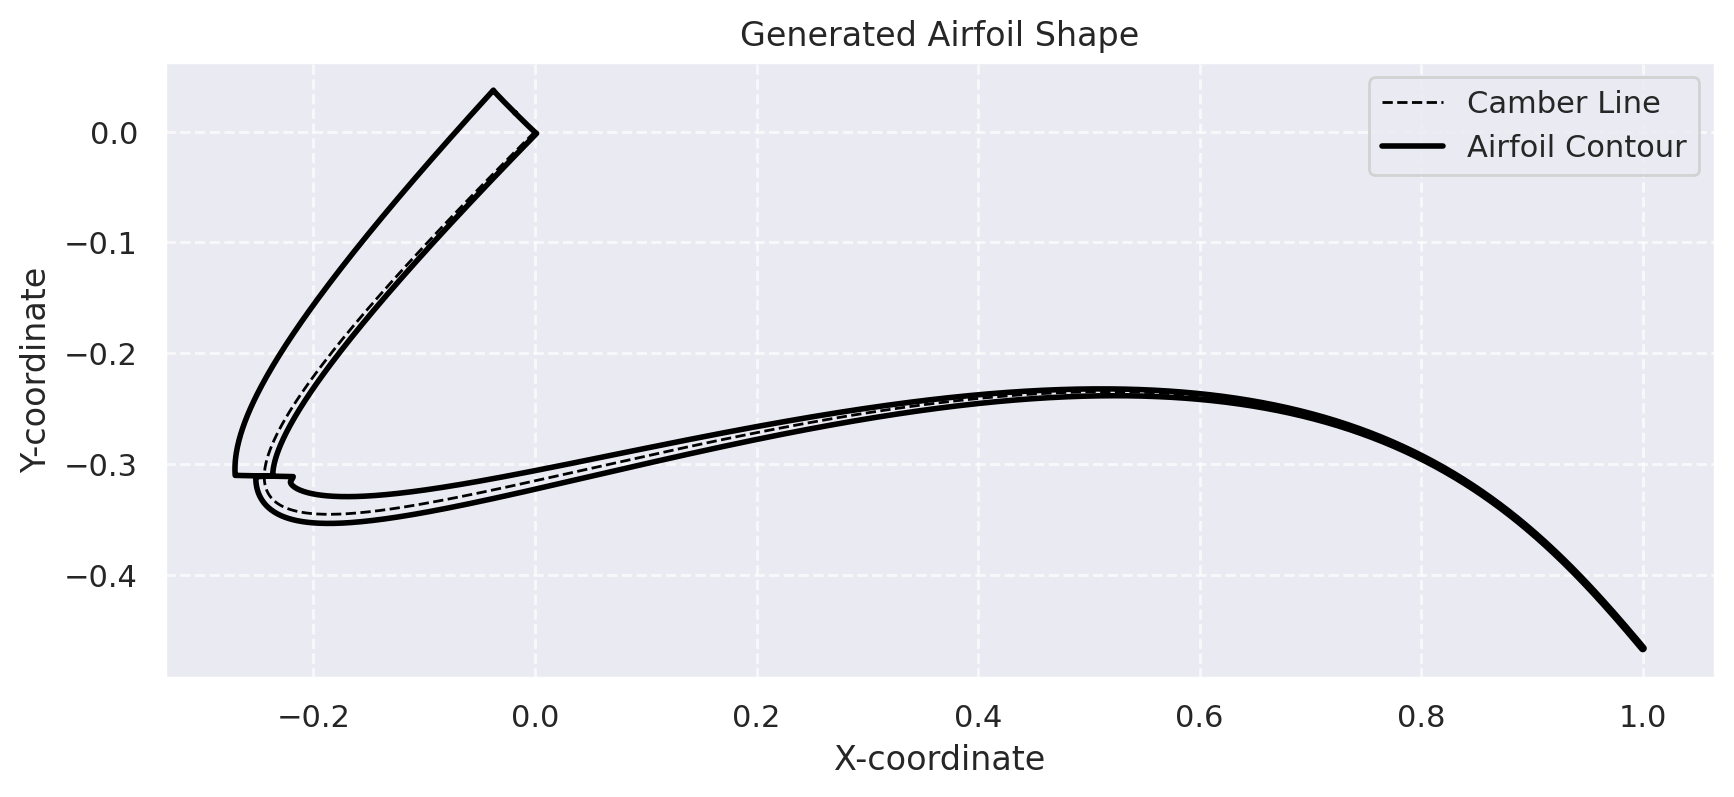

In [13]:
class Actor(nn.Module):
    def __init__(self, n_numbers, hidden_dim=128):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, hidden_dim),  # Simple state input (can be modified)
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_numbers * 2)  # Mean and log_std for each number
        )
        self.n_numbers = n_numbers
    def forward(self, state):
        params = self.network(state)
        mean, log_std = params[:, :self.n_numbers], params[:, self.n_numbers:]
        std = log_std.exp()
        dist = distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action, log_prob

class Critic(nn.Module):
    def __init__(self, n_numbers, hidden_dim=128):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2 + n_numbers, hidden_dim),  # State (dim 2) + action
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # Value estimate
        )
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.network(x)

def train_actor_critic(n_numbers, num_episodes=1000, lr_actor=1e-4, lr_critic=1e-4, gamma=0.90):
    actor = Actor(n_numbers)
    critic = Critic(n_numbers)
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr_actor)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr_critic)
    plot_foil = False
    state = torch.tensor([[1.0, 1.0]], dtype=torch.float32)
    for episode in range(num_episodes):
        action, log_prob = actor(state)
        reward, state = external_eval(action, plot_foil)
        # Critic estimates value
        value = critic(state, action)
        # Compute advantage
        advantage = reward - value.detach()
        # Critic loss: Mean squared error
        critic_loss = (reward - value).pow(2).mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        # Actor loss: Policy gradient
        actor_loss = -(log_prob * advantage).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        if episode % 50 == 0:
            print(f"Episode {episode}, Reward: {reward.item():.4f}, Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}")
            plot_foil = True
        else:
            plot_foil = False

if __name__ == "__main__":
    n_numbers = 4  # User-defined number of continuous outputs
    train_actor_critic(n_numbers)